<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    Data Preparation
</h1>

<h3 style="color:#555; text-align:left;">
    Handling mIssing values, outliers detection tratment, codification (categrical values), normalization, feature engineering and feature selection
</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

# **1: Data importation**

In [565]:
# ============================
# Standard library imports
# ============================
import os
import sys
from pathlib import Path

# ============================
# Third-party imports
# ============================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import scipy.stats as stats
from scipy.stats import chi2_contingency  # filter method

from sklearn.cluster import KMeans
import string


from xgboost import XGBClassifier

from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE, RFECV, mutual_info_classif  # wrapper + filter

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,  # possible model inside RFE
    LassoCV              # embedded method
)

from sklearn.tree import DecisionTreeClassifier  # embedded method
from sklearn.ensemble import RandomForestClassifier  # embedded method

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

# ============================
# Project-specific imports
# ============================
project_root = Path().resolve().parent
src_path = project_root / "src"
sys.path.append(str(src_path))

from utils_data import load_df, quick_overview


In [566]:
MASTER_NAME = "telco_master_basic_clean"

df = load_df(MASTER_NAME, folder="interim")
print(f"\nLoaded '{MASTER_NAME}' from interim with shape: {df.shape}")

📂 Loaded: C:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\data\interim\telco_master_basic_clean.csv

Loaded 'telco_master_basic_clean' from interim with shape: (7043, 31)


# **2: Data Separation: Hold-Out Method**

Data will be firstly separated in by train split in 80% to train + validation and 20% to final testing (Evaluation notebook).

In the data to train and validated (the 80%) will used 

In [567]:
target_col = 'st_churn_label'

# Full data (apenas variáveis intermédias)
y_full = df[target_col].copy()
X_full = df.drop(columns=[target_col])

# Hold-out final (20% recomendado; podes pôr 0.2 se quiseres mesmo 20%)
X, X_test_final, y, y_test_final = train_test_split(
    X_full,
    y_full,
    test_size=0.20,      # 20% porque o dataset é desbalanceado
    stratify=y_full,     # preserva % de Yes/No no split
    random_state=42
)

print("X (train/val) shape:", X.shape, y.shape)
print("X_test_final shape:", X_test_final.shape, y_test_final.shape)

X (train/val) shape: (5634, 30) (5634,)
X_test_final shape: (1409, 30) (1409,)


In [568]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}:")

    print("X_train: Nº index =", train_index.shape[0])
    print("train_index head(5) =", train_index[:5])

    print("X_val:   Nº index =", val_index.shape[0]) 
    print("val_index head(5) =", val_index[:5])

    print("-" * 30)

Fold 1:
X_train: Nº index = 4507
train_index head(5) = [1 3 4 5 6]
X_val:   Nº index = 1127
val_index head(5) = [ 0  2  8  9 28]
------------------------------
Fold 2:
X_train: Nº index = 4507
train_index head(5) = [0 2 3 4 5]
X_val:   Nº index = 1127
val_index head(5) = [ 1 10 13 17 19]
------------------------------
Fold 3:
X_train: Nº index = 4507
train_index head(5) = [0 1 2 5 8]
X_val:   Nº index = 1127
val_index head(5) = [ 3  4  6  7 14]
------------------------------
Fold 4:
X_train: Nº index = 4507
train_index head(5) = [0 1 2 3 4]
X_val:   Nº index = 1127
val_index head(5) = [ 5 11 12 21 24]
------------------------------
Fold 5:
X_train: Nº index = 4508
train_index head(5) = [0 1 2 3 4]
X_val:   Nº index = 1126
val_index head(5) = [15 16 23 26 36]
------------------------------


### Note on variable naming (`X`, `X_enc`, `X_test_final`)

- In this notebook, **`X` and `y` always refer to the data used for model training and cross-validation** (≈80% of the original dataset).
- Before any modelling step, we perform a **stratified hold-out split**:
  - `X`, `y` → training/validation data (used in Stratified K-Fold)
  - `X_test_final`, `y_test_final` → untouched final test set
- This convention allows us to **keep the variable names `X` and `X_enc` consistent across the notebook**, while still respecting good practice:
  the final test set is fully isolated and is only used once at the very end for the final performance evaluation.
- `X_enc` therefore represents the **encoded version of `X` (train/validation only)**, and `X_test_final_enc` is encoded later using the same fitted encoder.


# **3 Data Cleaning**
## **3.1 Data Types Clarification**

In [569]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4626 to 6017
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   demo_gender                            5634 non-null   object 
 1   demo_age                               5634 non-null   int64  
 2   demo_married                           5634 non-null   object 
 3   demo_number_of_dependents              5634 non-null   int64  
 4   loc_city                               5634 non-null   object 
 5   loc_zip_code                           5634 non-null   int64  
 6   loc_latitude                           5634 non-null   float64
 7   loc_longitude                          5634 non-null   float64
 8   svc_referred_a_friend                  5634 non-null   object 
 9   svc_number_of_referrals                5634 non-null   int64  
 10  svc_tenure_in_months                   5634 non-null   int64  
 11  svc_of

In [570]:
def classify_columns(df, max_ordinal_cardinality=10):
    binary_cols = []
    ordinal_cols = []
    continuous_cols = []
    object_cols = []

    for col in df.columns:
        s = df[col]
        
        # Drop NaNs for uniqueness checks
        non_null = s.dropna()
        unique_vals = non_null.unique()
        nunique = non_null.nunique()

        # 1) Boolean dtype
        if pd.api.types.is_bool_dtype(s):
            binary_cols.append(col)
            continue

        # 2) Categorical dtype
        if isinstance(s.dtype, pd.CategoricalDtype):

            # 2A) Ordinal categorical
            if s.dtype.ordered:
                ordinal_cols.append(col)
                continue

            # 2B) Nominal categorical
            else:
                object_cols.append(col)
                continue

        # 3) Object dtype (categorical not yet converted)
        if s.dtype == "object":
            if nunique == 2:
                binary_cols.append(col)
            else:
                object_cols.append(col)
            continue

        # 4) Numeric columns
        if pd.api.types.is_numeric_dtype(s):

            # Binary numeric (0/1)
            if set(unique_vals).issubset({0, 1}) and nunique <= 2:
                binary_cols.append(col)
                continue

            # Integer numeric
            if pd.api.types.is_integer_dtype(s):
                # treat as continuous discrete unless it's explicitly ordinal
                continuous_cols.append(col)
                continue

            # Float numeric
            if pd.api.types.is_float_dtype(s):
                continuous_cols.append(col)
                continue

        # 5) Fallback
        object_cols.append(col)

    return binary_cols, ordinal_cols, continuous_cols, object_cols

binary_cols, ordinal_cols, continuous_cols, object_cols = classify_columns(X)


In [571]:

def show_unique_values(df, columns, n=30):
    """
    df       -> DataFrame
    columns  -> lista de nomes de colunas
    n        -> número de valores únicos a mostrar (default = 10)
    """
    for col in columns:
        print(f"\n=== {col}: first {n} unique values ===")
        uniques = df[col].dropna().unique()[:n]
        print(uniques)

print('=====Binary Cols=====')
show_unique_values(X, binary_cols)
print('=====================')
print('=====Ordinal Cols=====')
show_unique_values(X, ordinal_cols)
print('======================')
print('=====Continuous Cols=====')
show_unique_values(X, continuous_cols)
print('=========================')
print('=====Object Cols=====')
show_unique_values(X, object_cols)


=====Binary Cols=====

=== demo_gender: first 30 unique values ===
['Male' 'Female']

=== demo_married: first 30 unique values ===
['No' 'Yes']

=== svc_referred_a_friend: first 30 unique values ===
['No' 'Yes']

=== svc_phone_service: first 30 unique values ===
['Yes' 'No']

=== svc_multiple_lines: first 30 unique values ===
['Yes' 'No']

=== svc_internet_service: first 30 unique values ===
['Yes' 'No']

=== svc_online_security: first 30 unique values ===
['No' 'Yes']

=== svc_online_backup: first 30 unique values ===
['Yes' 'No']

=== svc_device_protection_plan: first 30 unique values ===
['No' 'Yes']

=== svc_premium_tech_support: first 30 unique values ===
['No' 'Yes']

=== svc_streaming_tv: first 30 unique values ===
['No' 'Yes']

=== svc_streaming_movies: first 30 unique values ===
['No' 'Yes']

=== svc_streaming_music: first 30 unique values ===
['No' 'Yes']

=== svc_unlimited_data: first 30 unique values ===
['Yes' 'No']

=== svc_paperless_billing: first 30 unique values ===
['

## **3.1 Outliers Detection**

In [572]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
numeric_cols

Index(['demo_age', 'demo_number_of_dependents', 'loc_zip_code', 'loc_latitude',
       'loc_longitude', 'svc_number_of_referrals', 'svc_tenure_in_months',
       'svc_avg_monthly_long_distance_charges', 'svc_avg_monthly_gb_download',
       'svc_monthly_charge'],
      dtype='object')

In [573]:
def detect_outliers_iqr(df):
    outlier_summary = {}

    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # count outliers
        outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()

        # min and max
        col_min = df[col].min()
        col_max = df[col].max()

        outlier_summary[col] = {
            "Min": col_min,
            "Max": col_max,
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "Lower bound": lower,
            "Upper bound": upper,
            "Outlier count": outliers
        }

    return pd.DataFrame(outlier_summary).T

outlier_report = detect_outliers_iqr(X)
outlier_report

,Min,Max,Q1,Q3,IQR,Lower bound,Upper bound,Outlier count
demo_age,19.000000,80.000000,32.000000,60.000000,28.000000,-10.000000,102.000000,0.0
demo_number_of_dependents,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1289.0
loc_zip_code,90001.000000,96150.000000,92082.250000,95335.750000,3253.500000,87202.000000,100216.000000,0.0
loc_latitude,32.555828,41.962127,33.992416,38.183918,4.191502,27.705163,44.471171,0.0
loc_longitude,-124.301372,-114.192901,-121.780714,-117.993368,3.787346,-127.461732,-112.312349,0.0
svc_number_of_referrals,0.000000,11.000000,0.000000,3.000000,3.000000,-4.500000,7.500000,542.0
svc_tenure_in_months,1.000000,72.000000,9.000000,56.000000,47.000000,-61.500000,126.500000,0.0
svc_avg_monthly_long_distance_charges,0.000000,49.990000,9.252500,36.317500,27.065000,-31.345000,76.915000,0.0
svc_avg_monthly_gb_download,0.000000,85.000000,3.000000,27.000000,24.000000,-33.000000,63.000000,289.0
svc_monthly_charge,18.550000,118.750000,35.662500,90.050000,54.387500,-45.918750,171.631250,0.0


In [574]:
def compute_upper_bound(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return upper_bound

In [575]:
def remove_upper_outliers(df, col, upper_bound):
    df[col] = df[col].apply(lambda x: x if x <= upper_bound else None)
    return df


In [576]:
def cap_upper_outliers(df, col):
    # Calculate IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Upper bound
    upper_bound = Q3 + 1.5 * IQR

    # Round down to nearest integer
    capped_value = int(upper_bound // 1)   # floor

    # Replace values above upper bound
    df[col] = df[col].apply(lambda x: capped_value if x > upper_bound else x)

    print(f"Upper bound original: {upper_bound:.2f}")
    print(f"Upper bound rounded down: {capped_value}")
    return df


In [577]:
def plot_histogram(df, col):
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], bins=30, kde=False)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {col}")
    plt.tight_layout()
    plt.show()


In [578]:
def churn_table(df, col, target):
    """
    df     -> DataFrame (ex.: X ou df_clean)
    col    -> nome da coluna (string), ex.: "svc_number_of_referrals"
    target -> variável churn (string), ex.: y ou "st_churn_label"
    """

    # Create crosstab with churn percentages
    tabela = pd.crosstab(
        df[col],
        target,
        normalize="index"
    ) * 100

    # Rename columns (if they exist)
    if "Yes" in tabela.columns:
        tabela.rename(columns={"Yes": "Churn_%"}, inplace=True)
    if "No" in tabela.columns:
        tabela.rename(columns={"No": "No_Churn_%"}, inplace=True)

    # Add count column
    counts = df[col].value_counts().sort_index()
    tabela["count"] = counts

    # Display table
    display(tabela)

    return


### **3.2.1 Outliers in demo_number_of_dependents**

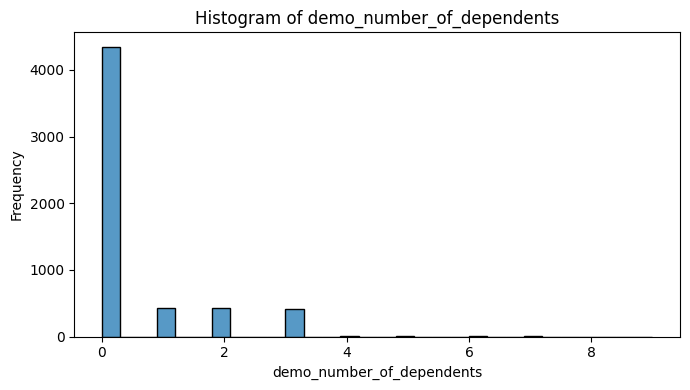

In [579]:
plot_histogram(X, "demo_number_of_dependents")


In [580]:
churn_table(X, "demo_number_of_dependents", y)

st_churn_label,No_Churn_%,Churn_%,count
demo_number_of_dependents,,,
0,67.640967,32.359033,4345
1,92.740047,7.259953,427
2,93.192488,6.807512,426
3,93.946731,6.053269,413
4,88.888889,11.111111,9
5,87.500000,12.500000,8
6,50.000000,50.000000,2
7,50.000000,50.000000,2
8,100.000000,0.000000,1


In this case is clear that:
 - Customers with no dependents have a churn rate higher than 30%;
 - Customers with at least 1 to 3 dependents the churn rate is lower than 10%;
 - Customers with more 4 ou more depents have churn rate higher than 12%, however its a very few number of samples;

This case is dificult to solve, since it will be dificult to avoid the existance of outliers (even 1 dependent is considered an outlier).
For this case the solution will be create a __Binary__ variable that is __"Has_dependents"__

### **3.2.2 Outliers in svc_number_of_referrals**

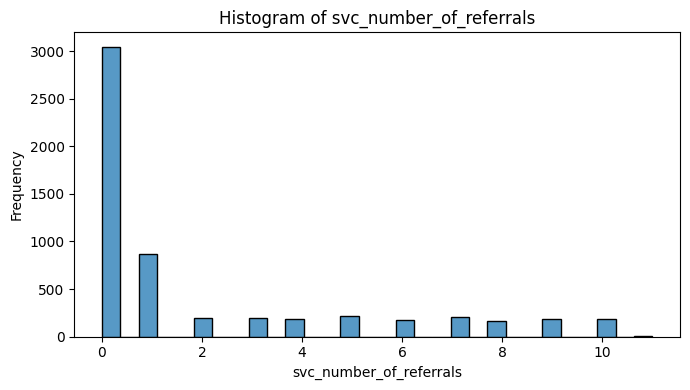

In [581]:
plot_histogram(X, "svc_number_of_referrals")



In [582]:
churn_table(X, "svc_number_of_referrals", y)


st_churn_label,No_Churn_%,Churn_%,count
svc_number_of_referrals,,,
0,67.301379,32.698621,3046
1,53.571429,46.428571,868
2,89.340102,10.659898,197
3,88.324873,11.675127,197
4,92.473118,7.526882,186
5,91.402715,8.597285,221
6,95.321637,4.678363,171
7,97.572816,2.427184,206
8,98.809524,1.190476,168


In this case is clear that:
 - Customers that have no number of referrals have an churn rate higher than 30%;
 - Customers with at least 1 referrals have churn rate higher than 47%;
 - Customers with 2 or more have churn rate lower than 12%;

The solution for this case will be to creat an Binning variable with several classes of referrals.

### **3.2.3 Outliers in svc_avg_monthly_gb_download**

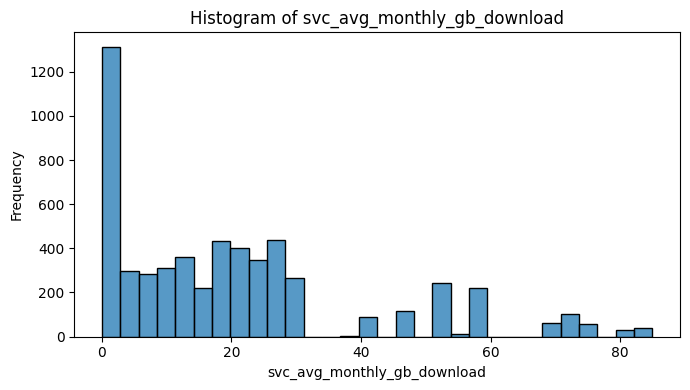

In [583]:
plot_histogram(X, "svc_avg_monthly_gb_download")

In [584]:
churn_table(X, "svc_avg_monthly_gb_download", y)

st_churn_label,No_Churn_%,Churn_%,count
svc_avg_monthly_gb_download,,,
0,92.522597,7.477403,1217
2,65.625000,34.375000,96
3,66.037736,33.962264,106
4,62.500000,37.500000,96
5,59.574468,40.425532,94
6,60.824742,39.175258,97
7,61.956522,38.043478,92
8,65.263158,34.736842,95
9,68.539326,31.460674,89


The variable svc_avg_monthly_gb_download shows a highly skewed distribution with a very heavy concentration of values near zero and a long, irregular tail extending up to ~85 GB this case needs to be solved creating bins. Again, the solution for this case will be to creat an Binning variable with several classes of referrals.

# **4 Data Transformation**
## **4.1 Creating new variables**
### **4.1.1 variable "Is_woman" (Binary)**

In [585]:
X["demo_gender"].value_counts(dropna=False)

demo_gender
Male      2866
Female    2768
Name: count, dtype: int64

In [586]:
X["demo_gender"].value_counts(dropna=False)

demo_gender
Male      2866
Female    2768
Name: count, dtype: int64

In [587]:
X_test_final["demo_gender"].value_counts(dropna=False)

demo_gender
Female    720
Male      689
Name: count, dtype: int64

In [588]:
X["Is_woman"] = X["demo_gender"].map({"Male": 0, "Female": 1})
X_test_final["Is_woman"] = X_test_final["demo_gender"].map({"Male": 0, "Female": 1})

In [589]:
X["Is_woman"].value_counts(dropna=False)

Is_woman
0    2866
1    2768
Name: count, dtype: int64

In [590]:
X_test_final["Is_woman"].value_counts(dropna=False)

Is_woman
1    720
0    689
Name: count, dtype: int64

### **4.1.2 variable "Has_dependents" (Binary)**

In [591]:
X["demo_number_of_dependents"].value_counts(dropna=False)

demo_number_of_dependents
0    4345
1     427
2     426
3     413
4       9
5       8
6       2
7       2
8       1
9       1
Name: count, dtype: int64

In [592]:
X["Has_dependents"] = X["demo_number_of_dependents"].apply(lambda x: 0 if x == 0 else 1)


In [593]:
X["Has_dependents"].value_counts(dropna=False)

Has_dependents
0    4345
1    1289
Name: count, dtype: int64

In [594]:
X_test_final["Has_dependents"] = X_test_final["demo_number_of_dependents"].apply(lambda x: 0 if x == 0 else 1)

## **4.2 Binarization**

In [595]:
binary_cols = [
    "demo_married",
    "svc_referred_a_friend",
    "svc_phone_service",
    "svc_multiple_lines",
    "svc_internet_service",
    "svc_online_security",
    "svc_online_backup",
    "svc_device_protection_plan",
    "svc_premium_tech_support",
    "svc_streaming_tv",
    "svc_streaming_movies",
    "svc_streaming_music",
    "svc_unlimited_data",
    "svc_paperless_billing",
]

# Convert Yes/No → 1/0
for col in binary_cols:
    if col in X.columns:
        X[col] = X[col].map({"Yes": 1, "No": 0})

# Test final
for col in binary_cols:
    if col in X_test_final.columns:
        X_test_final[col] = X_test_final[col].map({"Yes": 1, "No": 0})


# Quick check
print("Binary columns converted to 0/1:")
for col in binary_cols:
    if col in X.columns:
        print(col, X[col].unique())

print("Test :", {col: X_test_final[col].unique() for col in binary_cols if col in X_test_final.columns})

Binary columns converted to 0/1:
demo_married [0 1]
svc_referred_a_friend [0 1]
svc_phone_service [1 0]
svc_multiple_lines [1 0]
svc_internet_service [1 0]
svc_online_security [0 1]
svc_online_backup [1 0]
svc_device_protection_plan [0 1]
svc_premium_tech_support [0 1]
svc_streaming_tv [0 1]
svc_streaming_movies [0 1]
svc_streaming_music [0 1]
svc_unlimited_data [1 0]
svc_paperless_billing [0 1]
Test : {'demo_married': array([0, 1]), 'svc_referred_a_friend': array([0, 1]), 'svc_phone_service': array([1, 0]), 'svc_multiple_lines': array([1, 0]), 'svc_internet_service': array([1, 0]), 'svc_online_security': array([0, 1]), 'svc_online_backup': array([0, 1]), 'svc_device_protection_plan': array([0, 1]), 'svc_premium_tech_support': array([0, 1]), 'svc_streaming_tv': array([1, 0]), 'svc_streaming_movies': array([0, 1]), 'svc_streaming_music': array([0, 1]), 'svc_unlimited_data': array([1, 0]), 'svc_paperless_billing': array([1, 0])}


## **4.3 Encoding target variable**

In [596]:
# Convert target Yes/No → 1/0
y = y.map({"No": 0, "Yes": 1})

In [597]:
y_test_final = y_test_final.map({"No": 0, "Yes": 1})

## **4.4 Binning**
### **4.4.1 Variable svc_number_of_referrals**

The churn distribution across referral counts shows three clear behavioral patterns:

 - 0 and 1 referrals have very high churn (32.7% and 46.4%), but their churn levels differ significantly, so they should remain separate.

 - Referral counts from 2 to 6 all have very similar churn rates (between 4.7% and 11.7%), but each category has a small sample size. Grouping them creates a more stable and reliable feature.

 - Referral count = 7 shows extremely low churn (1.47%) and represents a clearly distinct customer segment.

Based on these observations, the optimal binning is:

 - 0, 1, 2–6, and 7

This approach reduces noise, avoids overfitting, and preserves meaningful behavioral differences for modeling.

In [598]:
# Bins e códigos para referrals
ref_bins = [-1, 0, 1, 6, float("inf")]
ref_codes = [0, 1, 2, 3]   # 0: "0", 1: "1", 2: "2–6", 3: "7+"

# Train
X["Referral_bin"] = pd.cut(
    X["svc_number_of_referrals"],
    bins=ref_bins,
    labels=ref_codes
).astype("Int64")

# Test
X_test_final["Referral_bin"] = pd.cut(
    X_test_final["svc_number_of_referrals"],
    bins=ref_bins,
    labels=ref_codes
).astype("Int64")


In [599]:
referral_labels = {0: "0", 1: "1", 2: "2-6", 3: "7+"}

#X["Referral_label"] = X["Referral_bin"].map(referral_labels)
#X_test_final["Referral_label"] = X_test_final["Referral_bin"].map(referral_labels)


### **4.4.2 Variable svc_avg_monthly_gb_download**

The variable svc_avg_monthly_gb_download shows a highly skewed distribution with a very heavy concentration of values near zero and a long, irregular tail extending up to ~85 GB.
This creates several problems:

 - Very small sample sizes in the upper tail (sometimes fewer than 20 customers per value),

 - Highly unstable churn rates for rare values,

  - Extreme sensitivity to noise in machine-learning models,

 - And distortion when applying standard outlier methods such as the IQR rule.

To address this, the variable was converted into meaningful, business-aligned bins.
Binning stabilizes the distribution by grouping rare values together, reduces noise, improves interpretability, and preserves the underlying behavioral patterns without removing data.
This approach creates a more reliable and model-friendl

In [600]:
# ------------------------------------------
# GB_download_bin (bins numericos 0–4)
# ------------------------------------------

gb_bins   = [-0.01, 10, 30, 60, float("inf")]
gb_labels = [1, 2, 3, 4]   # 1–10, 11–30, 31–60, 60+

# Train
X["GB_download_bin"] = pd.cut(
    X["svc_avg_monthly_gb_download"],
    bins=gb_bins,
    labels=gb_labels
).astype("Int64")

# Zeros tratados à parte
X.loc[X["svc_avg_monthly_gb_download"] == 0, "GB_download_bin"] = 0


# Test
X_test_final["GB_download_bin"] = pd.cut(
    X_test_final["svc_avg_monthly_gb_download"],
    bins=gb_bins,
    labels=gb_labels
).astype("Int64")

X_test_final.loc[X_test_final["svc_avg_monthly_gb_download"] == 0, "GB_download_bin"] = 0


In [601]:
gb_labels = {
    0: "0",
    1: "1–10",
    2: "11–30",
    3: "31–60",
    4: "60+"
}

X["GB_download_label"] = X["GB_download_bin"].map(gb_labels)
X_test_final["GB_download_label"] = X_test_final["GB_download_bin"].map(gb_labels)


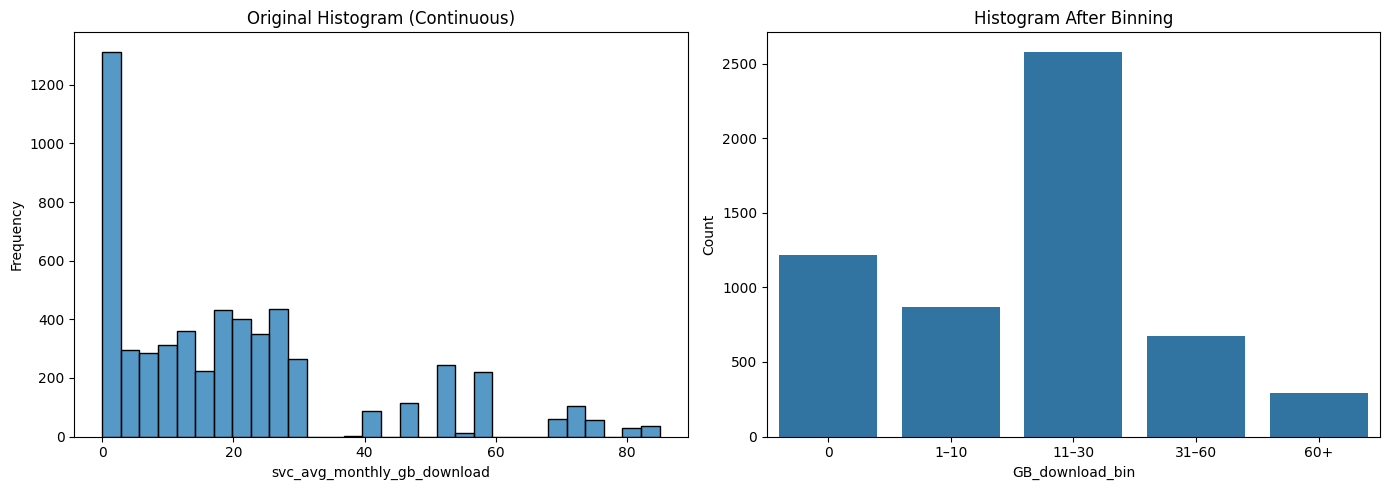

In [602]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# --- Histograma original (contínuo) ---
sns.histplot(X["svc_avg_monthly_gb_download"], bins=30, kde=False, ax=ax[0])
ax[0].set_title("Original Histogram (Continuous)")
ax[0].set_xlabel("svc_avg_monthly_gb_download")
ax[0].set_ylabel("Frequency")

# --- Histograma com bins (categorias) ---
sns.countplot(
    data=X,
    x="GB_download_label",
    order=["0", "1–10", "11–30", "31–60", "60+"],
    ax=ax[1]
)
ax[1].set_title("Histogram After Binning")
ax[1].set_xlabel("GB_download_bin")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

X = X.drop(columns=["GB_download_label"])
X_test_final = X_test_final.drop(columns=["GB_download_label"])


## **4.5 One-Hot Encoding**
### **4.5.1 Auxiliary functions**
#### **4.5.1.1 Function to perform One hot Encoding [without data leakage]**

In [603]:
def encode_data(dataset, to_encode_cols):

    ########################################## CREATE DUMMIES #################################################
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    # 1. Create dummies
    dummies = pd.get_dummies(dataset[to_encode_cols], drop_first=True)
    # 2. Remove original columns
    dataset_remaining = dataset.drop(columns=to_encode_cols)
    # 3. Merge everything
    final_dataset = pd.concat([dataset_remaining, dummies], axis=1)
    return final_dataset

#### **4.4.1.2 Function to verify nº of columns**

In [604]:
def check_same_columns(df1, df2):
    # Check number of columns
    if df1.shape[1] != df2.shape[1]:
        raise ValueError(
            f"ERROR: Dataframes have a different number of columns.\n"
            f"df1: {df1.shape[1]} columns | df2: {df2.shape[1]} columns"
        )
    
    # Check column names AND order
    if list(df1.columns) != list(df2.columns):
        raise ValueError(
            f"ERROR: Dataframes have different column names or different order.\n"
            f"df1 columns: {list(df1.columns)}\n"
            f"df2 columns: {list(df2.columns)}"
        )
    
    print("✔️ Dataframes have the same number of columns, same names, and same order.")


#### **4.4.1.3 Function to verify columns side by side**

In [605]:
def confirm_columns(df1, df2):
    """
    Print the columns of df1 and df2 side by side, in order.
    Useful to visually confirm if both dataframes are aligned.
    """
    print("Index | df1 column name  | df2 column name")
    print("-------------------------------------------")
    
    for i, (col1, col2) in enumerate(zip(df1.columns, df2.columns)):
        print(f"{i:5d} | {col1:20s} | {col2}")


#### **4.4.1.4 To change name of sample value**

In [606]:
def apply_mapping(df, col, mapping):
    """
    Aplica um mapping de substituição a uma coluna de um DataFrame.
    
    Exemplo:
        mapping = {"Offer A": "A", "No Offer": None}
        df = apply_mapping(df, "svc_offer", mapping)
    """
    df[col] = df[col].replace(mapping)
    return df

### **4.4.2 svc_internet type**

In [607]:
to_encode_cols=[]

In [608]:
X["svc_internet_type"].value_counts(dropna=False)

svc_internet_type
Fiber Optic    2428
DSL            1340
No Internet    1217
Cable           649
Name: count, dtype: int64

In [609]:
offer_mapping = {
    "Fiber Optic": "Fiber",
    "No Internet": "No",
}

X = apply_mapping(X, "svc_internet_type", offer_mapping)
X_test_final = apply_mapping(X_test_final, "svc_internet_type", offer_mapping)


In [610]:
X["svc_internet_type"].value_counts(dropna=False)

svc_internet_type
Fiber    2428
DSL      1340
No       1217
Cable     649
Name: count, dtype: int64

In [611]:
to_encode_cols.append("svc_internet_type")

### **4.4.3 svc_contract**

In [612]:
X["svc_contract"].value_counts(dropna=False)

svc_contract
Month-to-Month    2877
Two Year          1522
One Year          1235
Name: count, dtype: int64

In [613]:
offer_mapping = {
    "Month-to-Month": "Monthly",
    "Two Year": "2year",
    "One Year": "1year",
}

X = apply_mapping(X, "svc_contract", offer_mapping)
X_test_final = apply_mapping(X_test_final, "svc_contract", offer_mapping)

In [614]:
X["svc_contract"].value_counts(dropna=False)

svc_contract
Monthly    2877
2year      1522
1year      1235
Name: count, dtype: int64

In [615]:
to_encode_cols.append("svc_contract")

### **4.4.4 svc_payment_method**

In [616]:
X["svc_payment_method"].value_counts(dropna=False)

svc_payment_method
Bank Withdrawal    3128
Credit Card        2200
Mailed Check        306
Name: count, dtype: int64

In [617]:
offer_mapping = {
    "Bank Withdrawal": "Bank",
    "Credit Card": "Card",
    "Mailed Check": "Check",
}

X = apply_mapping(X, "svc_payment_method", offer_mapping)
X_test_final = apply_mapping(X_test_final, "svc_payment_method", offer_mapping)

In [618]:
to_encode_cols.append("svc_payment_method")

### **4.4.5 Referral_bin**

In [619]:
X["Referral_bin"] = X["Referral_bin"].astype("category")
X_test_final["Referral_bin"] = X_test_final["Referral_bin"].astype("category")
to_encode_cols.append("Referral_bin")
X["Referral_bin"].value_counts(dropna=False)

Referral_bin
0    3046
2     972
1     868
3     748
Name: count, dtype: int64

### **4.4.6 GB_download_bin**

In [620]:
X["GB_download_bin"] = X["GB_download_bin"].astype("category")
X_test_final["GB_download_bin"] = X_test_final["GB_download_bin"].astype("category")
to_encode_cols.append("GB_download_bin")
X["GB_download_bin"].value_counts(dropna=False)

GB_download_bin
2    2581
0    1217
1     871
3     676
4     289
Name: count, dtype: int64

### **4.4.7 svc_offer**

In [621]:
offer_mapping = {
    "Offer A": "A",
    "Offer B": "B",
    "Offer C": "C",
    "Offer D": "D",
    "Offer E": "E",
    "None": "No_Offer"
}

X = apply_mapping(X, "svc_offer", offer_mapping)
X_test_final = apply_mapping(X_test_final, "svc_offer", offer_mapping)


In [622]:
to_encode_cols.append("svc_offer")
X["svc_offer"].value_counts(dropna=False)

svc_offer
No Offer    3106
B            659
E            640
D            481
A            421
C            327
Name: count, dtype: int64

In [623]:
print(to_encode_cols)

['svc_internet_type', 'svc_contract', 'svc_payment_method', 'Referral_bin', 'GB_download_bin', 'svc_offer']


### **4.4.7 Categorical Variables Encoding**

In [624]:
# Encodar as variáveis assinaladas
X_enc = encode_data(X, to_encode_cols)

# Encodar as variáveis assinaladas
X_test_final_enc = encode_data(X_test_final, to_encode_cols)

**Confirm the structure of X and X_test**

In [625]:
confirm_columns(X, X_test_final)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_gender          | demo_gender
    1 | demo_age             | demo_age
    2 | demo_married         | demo_married
    3 | demo_number_of_dependents | demo_number_of_dependents
    4 | loc_city             | loc_city
    5 | loc_zip_code         | loc_zip_code
    6 | loc_latitude         | loc_latitude
    7 | loc_longitude        | loc_longitude
    8 | svc_referred_a_friend | svc_referred_a_friend
    9 | svc_number_of_referrals | svc_number_of_referrals
   10 | svc_tenure_in_months | svc_tenure_in_months
   11 | svc_offer            | svc_offer
   12 | svc_phone_service    | svc_phone_service
   13 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
   14 | svc_multiple_lines   | svc_multiple_lines
   15 | svc_internet_service | svc_internet_service
   16 | svc_internet_type    | svc_internet_type
   17 | svc_avg_monthly_gb_download | svc_avg_monthly_gb_dow

In [626]:
confirm_columns(X_enc, X_test_final_enc)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_gender          | demo_gender
    1 | demo_age             | demo_age
    2 | demo_married         | demo_married
    3 | demo_number_of_dependents | demo_number_of_dependents
    4 | loc_city             | loc_city
    5 | loc_zip_code         | loc_zip_code
    6 | loc_latitude         | loc_latitude
    7 | loc_longitude        | loc_longitude
    8 | svc_referred_a_friend | svc_referred_a_friend
    9 | svc_number_of_referrals | svc_number_of_referrals
   10 | svc_tenure_in_months | svc_tenure_in_months
   11 | svc_phone_service    | svc_phone_service
   12 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
   13 | svc_multiple_lines   | svc_multiple_lines
   14 | svc_internet_service | svc_internet_service
   15 | svc_avg_monthly_gb_download | svc_avg_monthly_gb_download
   16 | svc_online_security  | svc_online_security
   17 | svc_online_backup    | sv

In [627]:
check_same_columns(X, X_test_final)

✔️ Dataframes have the same number of columns, same names, and same order.


In [628]:
check_same_columns(X_enc, X_test_final_enc)

✔️ Dataframes have the same number of columns, same names, and same order.


## **4.6 Feature Engineering**

**Why we created geographic clusters**

To enhance the feature space and capture potential spatial patterns in customer behaviour, we grouped customers based on their geographic coordinates (latitude and longitude). Instead of treating location as continuous numeric variables, we applied a clustering algorithm (K-Means) to identify coherent geographic regions where customers share similar spatial characteristics.

This transformation serves two main purposes:

 - **Reduce noise and dimensionality** – raw coordinates provide little direct information to the model, but cluster assignments create a more interpretable and structured representation of geographic influence.

 - **Capture regional effects on churn** – factors such as service availability, network infrastructure, competition intensity, and socio-economic patterns often vary by location. Grouping customers into geographic clusters allows the model to learn these regional differences more effectively.

By converting raw coordinates into a single categorical “geo_cluster” variable, we retain meaningful spatial information while improving the model’s ability to generalise and identify location-driven churn behaviour.

In [629]:
lat_col = "loc_latitude"
lon_col = "loc_longitude"

# 1. Treinar clusters no X raw (treino+validação)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans.fit(X[[lat_col, lon_col]])

# 2. Aplicar ao X raw
X["geo_cluster"] = kmeans.predict(X[[lat_col, lon_col]])


# 3. Aplicar ao X_enc (igual ao X)
X_enc["geo_cluster"] = X["geo_cluster"].values

# 4. Aplicar ao teste raw
X_test_final["geo_cluster"] = kmeans.predict(
    X_test_final[[lat_col, lon_col]]
)


# 5. Aplicar ao teste encodado
X_test_final_enc["geo_cluster"] = X_test_final["geo_cluster"].values


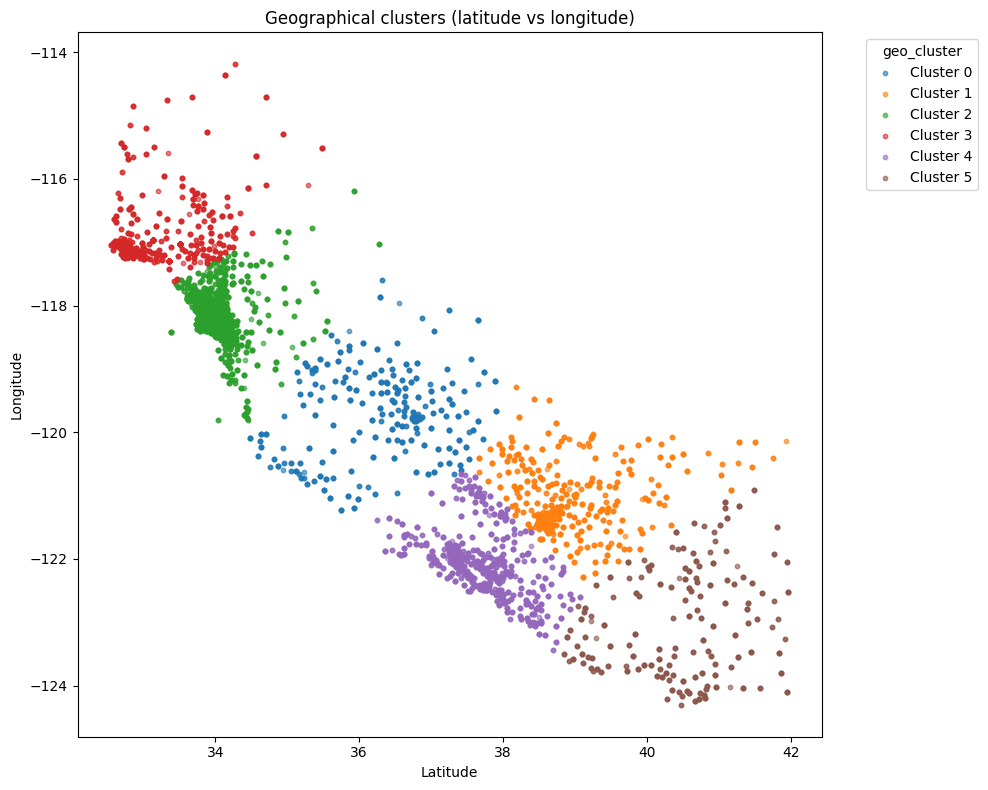

In [630]:
lat_col = "loc_latitude"
lon_col = "loc_longitude"

plt.figure(figsize=(10, 8))

# lista de clusters existentes
clusters = sorted(X["geo_cluster"].unique())

for c in clusters:
    mask = X["geo_cluster"] == c
    plt.scatter(
        X.loc[mask, lat_col],      # eixo X = latitude
        X.loc[mask, lon_col],      # eixo Y = longitude
        s=10,
        alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geographical clusters (latitude vs longitude)")
plt.legend(title="geo_cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


To ensure that the geographic cluster identifier is consistently treated as a categorical feature throughout the entire modelling pipeline, we converted the cluster numeric labels into alphabetical codes (e.g., “A”, “B”, “C”). While the original K-Means output is numeric, these numbers do not represent ordered or continuous values. By mapping each cluster to a letter, we explicitly reinforce the nominal nature of the variable and prevent any unintended interpretation of the clusters as ordinal or numeric during preprocessing or model training.

In [631]:
# Criar lista de letras A, B, C, ...
letters = list(string.ascii_uppercase)

# Criar dicionário de mapeamento (0→A, 1→B...)
cluster_to_letter = {i: letters[i] for i in range(X["geo_cluster"].nunique())}

# Aplicar aos datasets
X["geo_cluster"] = X["geo_cluster"].map(cluster_to_letter)
X_enc["geo_cluster"] = X_enc["geo_cluster"].map(cluster_to_letter)

X_test_final["geo_cluster"] = X_test_final["geo_cluster"].map(cluster_to_letter)
X_test_final_enc["geo_cluster"] = X_test_final_enc["geo_cluster"].map(cluster_to_letter)


In [632]:
#X = X.drop(columns=[lat_col, lon_col])
#X_test_final = X_test_final.drop(columns=[lat_col, lon_col])

#X_enc = X_enc.drop(columns=[lat_col, lon_col])
#X_test_final_enc = X_test_final_enc.drop(columns=[lat_col, lon_col])

In [633]:
# Encodar as variáveis assinaladas
to_encode_cols.append("geo_cluster")
X_enc = encode_data(X_enc, ["geo_cluster"])

# Encodar as variáveis assinaladas
X_test_final_enc = encode_data(X_test_final_enc, ["geo_cluster"])

# **5 Data Reduction**
## **5.1 Repeated Information, Unary or nearly unary variables**

In [634]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4626 to 6017
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   demo_gender                            5634 non-null   object  
 1   demo_age                               5634 non-null   int64   
 2   demo_married                           5634 non-null   int64   
 3   demo_number_of_dependents              5634 non-null   int64   
 4   loc_city                               5634 non-null   object  
 5   loc_zip_code                           5634 non-null   int64   
 6   loc_latitude                           5634 non-null   float64 
 7   loc_longitude                          5634 non-null   float64 
 8   svc_referred_a_friend                  5634 non-null   int64   
 9   svc_number_of_referrals                5634 non-null   int64   
 10  svc_tenure_in_months                   5634 non-null   int64  

In [635]:
#based on Creating of new variables and EDA conclusions, drop unneeded columns
cols_to_drop = [
    "demo_gender",                  #Cria variável Is_Woman
    "loc_city",                     #Removido por criação de variavel geo_cluster
    "loc_zip_code",                 #Removido por criação de variavel geo_cluster
    "loc_latitude",                 #Removido por criação de variavel geo_cluster
    "loc_longitude",                #Removido por criação de variavel geo_cluster
    "demo_number_of_dependents",    #Criação de variável binária "Has dependents
    "svc_number_of_referrals",      #Criação de bins ["Referral_bin"] 
    "svc_avg_monthly_gb_download"   #Criação de bins ["GB_download_bin"] 
#    "svc_internet_type",           #One Hot Encoded
#    "svc_contract",                #One Hot Encoded
#    "svc_payment_method",          #One Hot Encoded
#    "svc_offer",                   #One Hot Encoded
#    "geo_cluster"                  #One Hot Encoded
]

# Drop only those that exist (defensive)
existing_to_drop = [c for c in cols_to_drop if c in X.columns]

X = X.drop(columns=existing_to_drop)
X_test_final = X_test_final.drop(columns=existing_to_drop)

X_enc = X_enc.drop(columns=existing_to_drop)
X_test_final_enc = X_test_final_enc.drop(columns=existing_to_drop)

train_columns = X_enc.columns

# add missing columns
for col in train_columns:
    if col not in X_test_final_enc.columns:
        X_test_final_enc[col] = 0

# remove extra columns
X_test_final_enc = X_test_final_enc[train_columns]


print("Dropped columns:", existing_to_drop)
print("New shape:", X.shape)


Dropped columns: ['demo_gender', 'loc_city', 'loc_zip_code', 'loc_latitude', 'loc_longitude', 'demo_number_of_dependents', 'svc_number_of_referrals', 'svc_avg_monthly_gb_download']
New shape: (5634, 27)


In [636]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4626 to 6017
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   demo_age                               5634 non-null   int64   
 1   demo_married                           5634 non-null   int64   
 2   svc_referred_a_friend                  5634 non-null   int64   
 3   svc_tenure_in_months                   5634 non-null   int64   
 4   svc_offer                              5634 non-null   object  
 5   svc_phone_service                      5634 non-null   int64   
 6   svc_avg_monthly_long_distance_charges  5634 non-null   float64 
 7   svc_multiple_lines                     5634 non-null   int64   
 8   svc_internet_service                   5634 non-null   int64   
 9   svc_internet_type                      5634 non-null   object  
 10  svc_online_security                    5634 non-null   int64  

## **5.2 Brief Summary before Feature Selection**
### **5.2.1 Variables and Unique values by data types**

In [637]:

# -------------- BINARY VARIABLES (convert to int8) --------------
binary_cols = [
    "demo_married",
    "svc_referred_a_friend",
    "svc_phone_service",
    "svc_multiple_lines",
    "svc_internet_service",
    "svc_online_security",
    "svc_online_backup",
    "svc_device_protection_plan",
    "svc_premium_tech_support",
    "svc_streaming_tv",
    "svc_streaming_movies",
    "svc_streaming_music",
    "svc_unlimited_data",
    "svc_paperless_billing",
    "Is_woman",
    "Has_dependents"
]

#for col in binary_cols:
#    X[col] = X[col].astype("int8")

# -------------- NOMINAL CATEGORICAL --------------
object_cols = [
    "svc_internet_type",
    "svc_contract",
    "svc_payment_method",
    "Referral_bin",     # variavel que é numerica mas tem representação categorica"
    "GB_download_bin",  # variavel que é numerica mas tem representação categorica"
    "svc_offer",
    "geo_cluster"
]

#for col in object_cols:
#    X[col] = X[col].astype("category")

# -------------- CONTINUOUS NUMERIC --------------
continuous_cols = [
    "demo_age",
    "svc_avg_monthly_long_distance_charges",
    "svc_tenure_in_months",
    "svc_monthly_charge",
]

#for col in continuous_cols:
#    X[col] = X[col].astype(float)


### **5.2.2 Confirm Data Structure of X and X_final_test**

In [638]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4626 to 6017
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   demo_age                               5634 non-null   int64   
 1   demo_married                           5634 non-null   int64   
 2   svc_referred_a_friend                  5634 non-null   int64   
 3   svc_tenure_in_months                   5634 non-null   int64   
 4   svc_offer                              5634 non-null   object  
 5   svc_phone_service                      5634 non-null   int64   
 6   svc_avg_monthly_long_distance_charges  5634 non-null   float64 
 7   svc_multiple_lines                     5634 non-null   int64   
 8   svc_internet_service                   5634 non-null   int64   
 9   svc_internet_type                      5634 non-null   object  
 10  svc_online_security                    5634 non-null   int64  

In [639]:
confirm_columns(X, X_test_final)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_age             | demo_age
    1 | demo_married         | demo_married
    2 | svc_referred_a_friend | svc_referred_a_friend
    3 | svc_tenure_in_months | svc_tenure_in_months
    4 | svc_offer            | svc_offer
    5 | svc_phone_service    | svc_phone_service
    6 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
    7 | svc_multiple_lines   | svc_multiple_lines
    8 | svc_internet_service | svc_internet_service
    9 | svc_internet_type    | svc_internet_type
   10 | svc_online_security  | svc_online_security
   11 | svc_online_backup    | svc_online_backup
   12 | svc_device_protection_plan | svc_device_protection_plan
   13 | svc_premium_tech_support | svc_premium_tech_support
   14 | svc_streaming_tv     | svc_streaming_tv
   15 | svc_streaming_movies | svc_streaming_movies
   16 | svc_streaming_music  | svc_streaming_music
   17 | svc_unlimited

### **5.2.3 Confirm Data Structure of X_enc and X_final_test_enc**

In [640]:
X_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4626 to 6017
Data columns (total 44 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   demo_age                               5634 non-null   int64  
 1   demo_married                           5634 non-null   int64  
 2   svc_referred_a_friend                  5634 non-null   int64  
 3   svc_tenure_in_months                   5634 non-null   int64  
 4   svc_phone_service                      5634 non-null   int64  
 5   svc_avg_monthly_long_distance_charges  5634 non-null   float64
 6   svc_multiple_lines                     5634 non-null   int64  
 7   svc_internet_service                   5634 non-null   int64  
 8   svc_online_security                    5634 non-null   int64  
 9   svc_online_backup                      5634 non-null   int64  
 10  svc_device_protection_plan             5634 non-null   int64  
 11  svc_pr

In [641]:
confirm_columns(X_enc, X_test_final_enc)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_age             | demo_age
    1 | demo_married         | demo_married
    2 | svc_referred_a_friend | svc_referred_a_friend
    3 | svc_tenure_in_months | svc_tenure_in_months
    4 | svc_phone_service    | svc_phone_service
    5 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
    6 | svc_multiple_lines   | svc_multiple_lines
    7 | svc_internet_service | svc_internet_service
    8 | svc_online_security  | svc_online_security
    9 | svc_online_backup    | svc_online_backup
   10 | svc_device_protection_plan | svc_device_protection_plan
   11 | svc_premium_tech_support | svc_premium_tech_support
   12 | svc_streaming_tv     | svc_streaming_tv
   13 | svc_streaming_movies | svc_streaming_movies
   14 | svc_streaming_music  | svc_streaming_music
   15 | svc_unlimited_data   | svc_unlimited_data
   16 | svc_paperless_billing | svc_paperless_billing
   17 |

# **6 Feature Selection**

**Feature Selection Pipeline Overview**

In this notebook, we apply three groups of feature selection techniques:

    **1 - Filter Methods**
    **2 - Wrapper Methods (RFE / RFECV)**
    **3 - Embedded Methods (model-based importance)**

These methods are executed in a deliberate order because each stage plays a different role in reducing dimensionality and improving model stability.

    **1. Filter Methods – Fast Statistical Screening**

Filter methods rely on mathematical or statistical criteria (variance, correlation, chi-square, etc.) and do not use any machine learning model.
They remove:

 - near-constant features
 - redundant variables
 - irrelevant variables
 - highly correlated / collinear features

**Goal:** clean and reduce the feature space before more expensive methods are used.

    **2. Wrapper Methods – Performance-Based Selection (RFE / RFECV)**

Wrapper methods evaluate subsets of features by training a model repeatedly.
Examples: **RFE, RFECV**.

They work by:

 - fitting a model
 - ranking features
 - recursively removing the least important
 - optionally using cross-validation to find the optimal number of features

Wrappers are powerful but computationally expensive and sensitive to noise, which is why they must be run after filters.

**Goal:** identify the feature subset that gives the best predictive performance.

    **3. Embedded Methods – Model-Driven Feature Importance**

Embedded methods perform feature selection inside the learning algorithm.
Examples:

 - Logistic Regression (L1 regularization)
 - Random Forest feature importance
 - XGBoost feature importance

These models naturally penalize irrelevant features and highlight the most predictive ones.

**Goal:** provide a final, stable importance ranking based on trained models.


## **6.1 Filter Methods**
### **6.1.1 Pre-filtering: Variance [Continuous, ordinal and binary data]**
**Purpose:**

Remove features that have very low variance, meaning they barely change and carry almost no information.

**Used for:**
- Detecting features that are almost all zeros or all ones
- Identifying variables with a dominant value
- Cleaning noise before further feature selection tests

**Why it matters:**

Low-variance features don’t help predictive models and may make them worse.

**Binary variables (0/1)**

The maximum variance occurs when the classes are balanced (50 percent each).
Very low variance occurs when almost all values are the same (for example, 99 percent zeros).

Practical rule: remove binary features with variance lower than 0.01, because they indicate extremely imbalanced values.

**Continuous variables (not normalized)**

Because the scale directly affects variance, there is no universal threshold.

Practical rule: If you did not normalize the data, inspect the distribution of variances and remove features in the lower tail.
Alternatively, normalize the data (for example, using StandardScaler) and then apply a threshold.

**Continuous variables after normalization (mean 0, standard deviation 1)**

After standardizing the data, most features have variance close to 1.
If a feature still has variance close to zero after scaling, it means the feature was almost constant and carries little useful information.



In [642]:
# ==========================================================
#   CLEAN VARIANCE CHECK FOR FEATURE SCREENING
# ==========================================================

def check_feature_variances(X, binary_cols, continuous_cols, ordinal_cols, low_variance_threshold=0.01):

    print("\n================ VARIANCE CHECK ================\n")

    results = []

    for col in binary_cols:
        var = X[col].var()
        results.append((col, "binary", var))

    for col in continuous_cols:
        var = X[col].var()
        results.append((col, "continuous", var))

    for col in ordinal_cols:
        var = X[col].var()
        results.append((col, "ordinal", var))

    var_df = pd.DataFrame(results, columns=["feature", "type", "variance"])

    # Sort by variance (useful for detection of low-variance features)
    var_df = var_df.sort_values("variance")

    print(var_df)

    # Identify problematic variables
    zero_var = var_df[var_df["variance"] == 0]
    low_var = var_df[var_df["variance"] < low_variance_threshold]

    print("\n------ SUMMARY ------")

    if len(zero_var) > 0:
        print("\nFeatures with ZERO variance (constant values):")
        print(zero_var)

    if len(low_var) > 0:
        print("\nFeatures with LOW variance (below threshold):")
        print(low_var)

    if len(zero_var) == 0 and len(low_var) == 0:
        print("\nNo issues detected. All features have acceptable variance.")

    print("\n================================================\n")

    return var_df


In [643]:
var_df = check_feature_variances(
    X_enc,
    binary_cols,
    continuous_cols,
    ordinal_cols,
    low_variance_threshold=0.01   # podes ajustar
)



================ VARIANCE CHECK ================

                                  feature        type    variance
2                       svc_phone_service      binary    0.086819
4                    svc_internet_service      binary    0.169380
15                         Has_dependents      binary    0.176476
5                     svc_online_security      binary    0.203987
8                svc_premium_tech_support      binary    0.206689
12                     svc_unlimited_data      binary    0.219411
6                       svc_online_backup      binary    0.225754
7              svc_device_protection_plan      binary    0.226577
11                    svc_streaming_music      binary    0.230079
9                        svc_streaming_tv      binary    0.237657
10                   svc_streaming_movies      binary    0.238396
13                  svc_paperless_billing      binary    0.240547
3                      svc_multiple_lines      binary    0.244380
1                   svc_r

### **6.1.2 Chi-Square (χ²) Test [Categorical data]**

**Purpose:**

Test whether there is a statistical association between a categorical/binary feature and a categorical target.

**Used for:**
 - Binary features vs. target
 - Categorical features vs. target

**Why it matters:**

Shows which categorical features are relevant for predicting churn.

In [644]:

# ==========================================================
#   CHI-SQUARE FEATURE SCREENING (CATEGORICAL + BINARY)
# ==========================================================

def select_best_cat_features(X, y, alpha=0.05, print_table=True):
    """
    Perform univariate Chi-Square tests between each categorical/binary feature
    and the target y (classification).

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix (before encoding).
    y : pd.Series or array-like
        Target variable (categorical or binary).
    alpha : float
        Significance level for marking features as "significant".
    print_table : bool
        If True, prints the sorted results.

    Returns
    -------
    chi_df : pd.DataFrame
        DataFrame with columns:
        ['feature', 'chi2', 'p_value', 'dof', 'significant']
        sorted by ascending p_value (most significant first).
    """
    results = []

    # 1) Identify categorical and binary features
    cat_cols = list(X.select_dtypes(include=["object", "category"]).columns)

    binary_cols = [
        col for col in X.columns
        if X[col].dtype in ["int64", "int32", "int16", "int8"]
        and X[col].nunique() == 2
    ]

    selected_cols = cat_cols + binary_cols

    print("\n================ CHI-SQUARE FEATURE SELECTION ================\n")
    print(f"Categorical features: {cat_cols}")
    print(f"Binary (int) features: {binary_cols}\n")

    # 2) Chi-Square test for each selected feature
    for col in selected_cols:
        # Build contingency table between feature and target
        contingency = pd.crosstab(X[col], y)

        # If contingency table is degenerate (e.g., only 1 unique value), skip
        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            chi2 = float("nan")
            p_value = float("nan")
            dof = 0
        else:
            chi2, p_value, dof, expected = chi2_contingency(contingency)

        results.append((col, chi2, p_value, dof))

    # 3) Build result DataFrame
    chi_df = pd.DataFrame(
        results,
        columns=["feature", "chi2", "p_value", "dof"]
    )

    # 4) Mark significance and sort by p-value
    chi_df["significant"] = chi_df["p_value"] < alpha
    chi_df = chi_df.sort_values("p_value", ascending=True).reset_index(drop=True)

    if print_table:
        print(chi_df)

        print("\n------ SUMMARY ------")
        sig = chi_df[chi_df["significant"] == True]
        if len(sig) > 0:
            print(f"\nFeatures with p < {alpha} (statistically significant):")
            print(sig)
        else:
            print(f"\nNo feature is statistically significant at alpha = {alpha}.")

        print("\n=============================================================\n")

    return chi_df


In [645]:
chi_df = select_best_cat_features(X, y, alpha=0.05)



================ CHI-SQUARE FEATURE SELECTION ================

Categorical features: ['svc_offer', 'svc_internet_type', 'svc_contract', 'svc_payment_method', 'Referral_bin', 'GB_download_bin', 'geo_cluster']
Binary (int) features: ['demo_married', 'svc_referred_a_friend', 'svc_phone_service', 'svc_multiple_lines', 'svc_internet_service', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'Is_woman', 'Has_dependents']

                       feature         chi2        p_value  dof  significant
0                 svc_contract  1181.908071  2.248658e-257    2         True
1                 Referral_bin   634.434632  3.452124e-137    3         True
2            svc_internet_type   528.642267  2.958901e-114    3         True
3                    svc_offer   365.823068   6.851917e-77    5         True
4               Has_depend

### **6.1.3 Spearman Correlation (ρ) [Continuous and ordinal data]**
**Purpose:**

Measure the monotonic relationship between a numerical feature and the target.

**Used for:**
 - Continuous variables
 - Ordinal variables
 - Non-linear but monotonic trends

**Why it matters:**

Robust to outliers and does not assume linearity — very appropriate for telecom churn data.

In [646]:
# =============================================================
#   SPEARMAN CORRELATION - USING ENCODED DATA
# =============================================================

def plot_spearman_heatmap_encoded(X, object_cols, figsize=(12, 10)):
    """
    Plots a Spearman correlation heatmap using the encoded dataset.
    Only numeric columns are kept.
    """
    # 1) Encode categóricas
    X_enc = encode_data(X, object_cols)

    # 2) Garantir só colunas numéricas
    X_num = X_enc.select_dtypes(include=["number"])

    # 3) Matriz de correlação Spearman
    corr_spear = X_num.corr(method="spearman")

    # 4) Heatmap com clustering
    sns.clustermap(
        corr_spear,
        cmap="coolwarm",
        linewidths=0.5,
        figsize=figsize,
        annot=False,
        center=0
    )
    plt.suptitle("Spearman Correlation Heatmap (Encoded Features)", y=1.02, fontsize=14)
    plt.show()

    return corr_spear


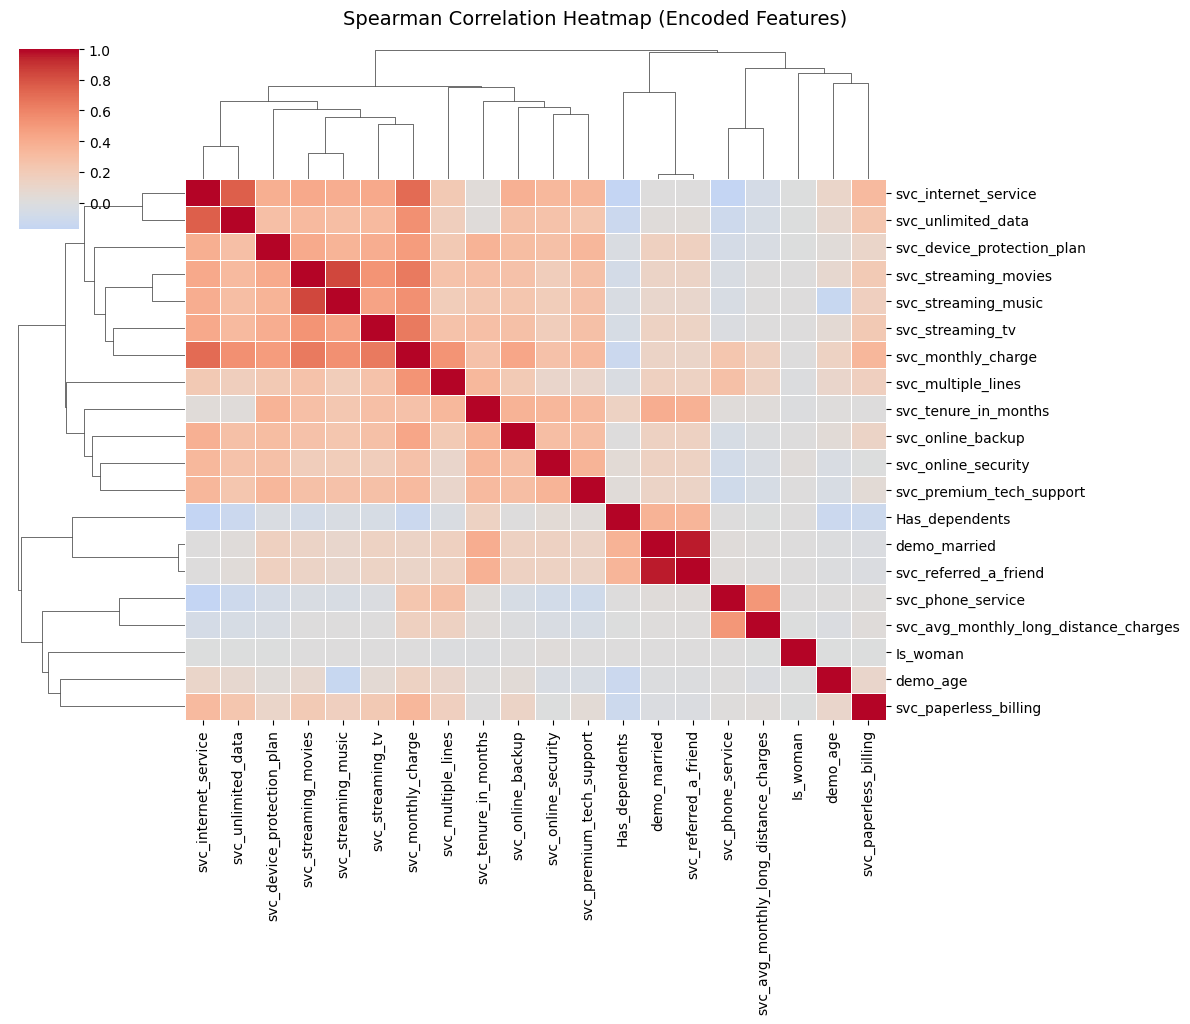

In [647]:
corr_spear = plot_spearman_heatmap_encoded(X, object_cols)


In [648]:
def high_correlations(corr_matrix, threshold=0.7):
    """
    Returns pairs of features with absolute correlation above the threshold.
    Useful to detect multicollinearity.
    """
    corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) >= threshold:
                corr_pairs.append((
                    corr_matrix.index[i],
                    corr_matrix.columns[j],
                    corr_value
                ))

    high_corr_df = pd.DataFrame(corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
    high_corr_df = high_corr_df.sort_values(by="Correlation", key=lambda x: abs(x), ascending=False)

    return high_corr_df


In [649]:
high_corr_df = high_correlations(corr_spear, threshold=0.7)
high_corr_df


,Feature 1,Feature 2,Correlation
0,demo_married,svc_referred_a_friend,0.950342
3,svc_streaming_movies,svc_streaming_music,0.841080
1,svc_internet_service,svc_unlimited_data,0.756485
2,svc_internet_service,svc_monthly_charge,0.710264


### **6.1.4 Mutual Information (MI) Test [Continuous,categorical and binary data]**
**Purpose:**

Measure how much a feature reduces uncertainty about the target — captures any type of dependence, linear or non-linear.

**Used for:**
 - Numerical features
 - Binary features
 - One-hot encoded categorical features
 - Complex/non-linear relationships

**Why it matters:**

One of the strongest filter methods for feature selection because it detects relationships that correlations cannot.

In [650]:
# =============================================================
#    MUTUAL INFORMATION (CORRECT - NO SPLITS)
# =============================================================

def compute_mutual_information(X, y, object_cols):
    """
    Compute Mutual Information between each encoded feature and the target.
    Works for classification problems.
    """

    # 1) Encode X (usar a tua encode_data!)
    X_enc = encode_data(X, object_cols)

    # 2) Garantir y é binário (0/1)
    y_num = y.astype(int)

    # 3) Calcular MI
    mi = mutual_info_classif(X_enc, y_num, discrete_features="auto")

    # 4) Construir DataFrame para ordenar
    mi_df = pd.DataFrame({
        "feature": X_enc.columns,
        "mutual_info": mi
    })

    mi_df = mi_df.sort_values("mutual_info", ascending=False).reset_index(drop=True)

    print("\n================ MUTUAL INFORMATION ================")
    print(mi_df)
    print("\nFeatures com maior dependência do target no topo.")
    print("====================================================\n")

    return mi_df


In [651]:
mi_df = compute_mutual_information(X, y, object_cols)



================ MUTUAL INFORMATION ================
                                  feature  mutual_info
0                    svc_contract_Monthly     0.117568
1                    svc_tenure_in_months     0.073826
2                      svc_contract_2year     0.068408
3                      svc_monthly_charge     0.051632
4                 svc_internet_type_Fiber     0.044717
5                          Referral_bin_3     0.039135
6                 svc_payment_method_Card     0.031850
7                          Has_dependents     0.031704
8                    svc_internet_type_No     0.030964
9                    svc_internet_service     0.028469
10                         Referral_bin_2     0.025777
11                      GB_download_bin_2     0.021236
12                  svc_paperless_billing     0.020532
13                            svc_offer_E     0.020101
14                   svc_streaming_movies     0.017826
15               svc_premium_tech_support     0.016150
16         

In [652]:
def plot_mi_bar_grouped(
    mi_df,
    binary_cols,
    continuous_cols,
    ordinal_cols,
    cutoff=None,
    title="Mutual Information por tipo de variável",
    top_n=None,
    score_col="mutual_info"
):
    """
    Plota um gráfico de barras horizontal da Mutual Information, com cores por tipo de variável.

    Parameters
    ----------
    mi_df : pd.DataFrame
        DataFrame com pelo menos as colunas ['feature', score_col].
    binary_cols : list
        Lista de nomes de colunas binárias (0/1) no espaço original / encoded.
    continuous_cols : list
        Lista de colunas numéricas contínuas.
    ordinal_cols : list
        Lista de colunas ordinais.
    cutoff : float or None
        Valor para desenhar linha de corte vertical (ex: 0.02). Se None, não desenha.
    title : str
        Título do gráfico.
    top_n : int or None
        Se definido, plota apenas as top N features com maior MI.
    score_col : str
        Nome da coluna no mi_df que contém os scores de MI (por defeito 'mutual_info').
    """

    if score_col not in mi_df.columns:
        raise ValueError(f"mi_df precisa de ter a coluna '{score_col}'")

    # 1) Série com scores, index = feature
    mi_scores = mi_df.set_index("feature")[score_col].dropna().sort_values(ascending=True)

    # top N (opcional)
    if top_n is not None:
        mi_scores = mi_scores.tail(top_n)

    # 2) Identificar colunas categóricas/dummies = tudo o que não está nas listas base
    base_cols = set(binary_cols + continuous_cols + ordinal_cols)
    cat_dummy_cols = [col for col in mi_scores.index if col not in base_cols]

    # 3) Mapear cada coluna a um tipo
    feature_types = {}
    for col in mi_scores.index:
        if col in binary_cols:
            feature_types[col] = "binary"
        elif col in continuous_cols:
            feature_types[col] = "continuous"
        elif col in ordinal_cols:
            feature_types[col] = "ordinal"
        elif col in cat_dummy_cols:
            feature_types[col] = "categorical"
        else:
            feature_types[col] = "unknown"

    # 4) Cores por tipo
    color_map = {
        "binary": "tab:blue",
        "continuous": "tab:green",
        "ordinal": "tab:orange",
        "categorical": "tab:red",
        "unknown": "grey"
    }
    bar_colors = [color_map[feature_types[col]] for col in mi_scores.index]

    # 5) Plot
    plt.figure(figsize=(12, max(6, len(mi_scores) * 0.3)))
    plt.barh(mi_scores.index, mi_scores.values, color=bar_colors)

    plt.title(title, fontsize=14)
    plt.xlabel(score_col, fontsize=12)
    plt.ylabel("Features", fontsize=12)

    # 6) Linha de corte (vertical, porque gráfico é horizontal)
    if cutoff is not None:
        plt.axvline(x=cutoff, linestyle="--", linewidth=1.5)
        plt.text(
            cutoff,
            -0.5,
            f"cutoff = {cutoff:.3f}",
            ha="center",
            va="bottom"
        )

    # 7) Legenda
    legend_elements = [
        Patch(facecolor=color_map["binary"], label="Binary"),
        Patch(facecolor=color_map["continuous"], label="Continuous"),
        Patch(facecolor=color_map["ordinal"], label="Ordinal"),
        Patch(facecolor=color_map["categorical"], label="Categorical (dummies)")
    ]
    plt.legend(handles=legend_elements, loc="lower right")

    plt.tight_layout()
    plt.show()


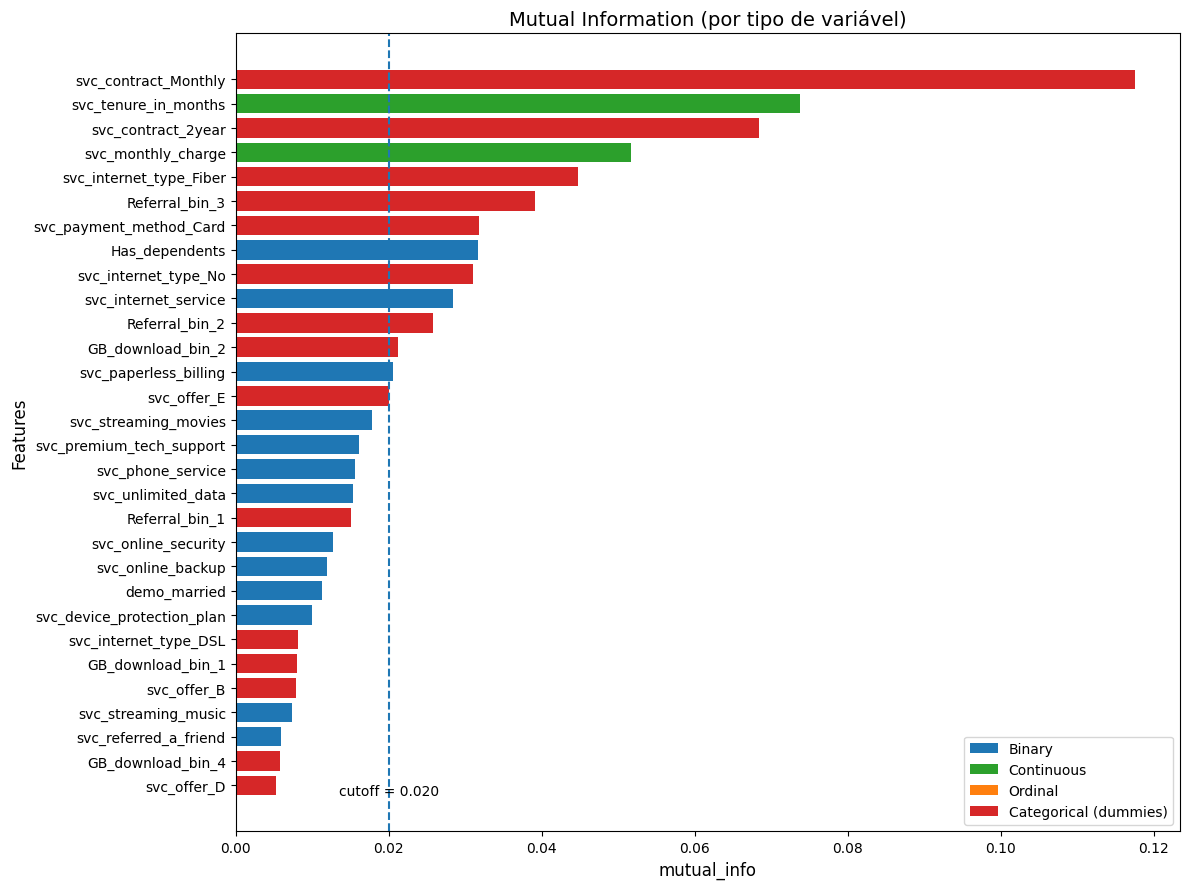

In [653]:
plot_mi_bar_grouped(
    mi_df,
    binary_cols=binary_cols,
    continuous_cols=continuous_cols,
    ordinal_cols=ordinal_cols,
    cutoff=0.02,                 # por exemplo
    title="Mutual Information (por tipo de variável)",
    top_n=30                     # por ex: top 30
)


### **6.1.5 Multicollinearity Correlation Check [Continuous, ordinal and binary data]**
**Method used:**

Feature-to-feature correlation (Pearson) — NOT feature vs target.

**Purpose:**

Identify pairs of features that are highly similar or redundant.

**Rules of thumb:**
 - |correlation| > 0.80 → suspicious
 - |correlation| > 0.85 → redundant
 - |correlation| > 0.90 → problematic

**Why it matters:**

Highly correlated features cause redundancy and can harm:
 - linear models
 - RFE
 - model stability
 - interpretability

In [654]:

def multicollinearity_correlation(X, 
                                  binary_cols,
                                  continuous_cols,
                                  ordinal_cols,
                                  object_cols,
                                  threshold=0.8):

    print("\n" + "="*120)
    print("                  CHECK DE MULTICOLINEARIDADE - CORRELAÇÃO ENTRE FEATURES")
    print("="*120)

    # 1) One Hot Encoding das variáveis categóricas
    X_enc = encode_data(X.copy(), object_cols)

    # 2) Selecionar apenas colunas numéricas
    numeric_cols = binary_cols + continuous_cols + ordinal_cols
    # acrescentar dummies criadas pelo encode_data (tudo o que não é numérico base nem objecto original)
    numeric_cols += [col for col in X_enc.columns if col not in numeric_cols and col not in object_cols]
    # remover duplicados mantendo ordem
    numeric_cols = list(dict.fromkeys(numeric_cols))

    X_num = X_enc[numeric_cols].select_dtypes(include=[np.number])

    # 3) Matriz de correlação absoluta
    corr_matrix = X_num.corr().abs()

    # 4) Zona superior da matriz (evita pares duplicados)
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # 5) Detetar pares com correlação acima do limiar
    high_corr_pairs = [
        (row, col, upper.loc[row, col])
        for row in upper.index
        for col in upper.columns
        if upper.loc[row, col] > threshold
    ]

    print(f"\nPares com correlação absoluta > {threshold}:\n")
    if len(high_corr_pairs) == 0:
        print("  Não foram encontrados pares com correlação elevada.")
    else:
        for f1, f2, val in high_corr_pairs:
            print(f"{f1}  <-->  {f2}   | corr = {val:.2f}")

    # 🔹 devolve 4 coisas
    return X_enc, X_num, corr_matrix, high_corr_pairs


In [655]:
# 1) Correlação entre features
X_enc_corr, X_num_corr, corr_matrix, high_corr_pairs = multicollinearity_correlation(
    X=X,
    binary_cols=binary_cols,
    continuous_cols=continuous_cols,
    ordinal_cols=ordinal_cols,
    object_cols=object_cols,
    threshold=0.7
)


                  CHECK DE MULTICOLINEARIDADE - CORRELAÇÃO ENTRE FEATURES

Pares com correlação absoluta > 0.7:

demo_married  <-->  svc_referred_a_friend   | corr = 0.95
svc_internet_service  <-->  svc_unlimited_data   | corr = 0.76
svc_internet_service  <-->  svc_monthly_charge   | corr = 0.76
svc_streaming_movies  <-->  svc_streaming_music   | corr = 0.84


### **6.1.6 Multicollinearity Check with VIF (Variance Inflation Factor) [Continuous, ordinal and binary data]**
**Method used:**

Regression-based method to compute:

𝑉𝐼𝐹=1/(1-R²) 

**Purpose:**

Quantify how much a feature is explained by the other features in the model.

**Interpretation:**
 - VIF = 1 → no collinearity
 - VIF = 2–5 → moderate
 - VIF > 5 → concerning
 - VIF > 10 → serious multicollinearity
 - VIF = ∞ → feature is a perfect linear combination of others

**Why it matters:**

VIF is the most formal and widely used measure of structural redundancy among variables.

In [656]:
def multicollinearity_vif_manual(X, 
                                 binary_cols,
                                 continuous_cols,
                                 ordinal_cols,
                                 object_cols):

    print("\n" + "="*120)
    print("          CHECK DE MULTICOLINEARIDADE - VIF (Variance Inflation Factor, sem statsmodels)")
    print("="*120)

    # 1) One Hot Encoding
    X_enc = encode_data(X.copy(), object_cols)

    # 2) Seleção das colunas numéricas
    numeric_cols = binary_cols + continuous_cols + ordinal_cols
    numeric_cols += [col for col in X_enc.columns if col not in numeric_cols and col not in object_cols]
    numeric_cols = list(dict.fromkeys(numeric_cols))

    X_num = X_enc[numeric_cols].select_dtypes(include=[np.number]).copy()

    vif_data = []

    # 3) Calcular VIF manualmente para cada feature
    for col in X_num.columns:
        y_feature = X_num[col]
        X_others = X_num.drop(columns=[col])

        if X_others.shape[1] == 0:
            vif = 1.0
        else:
            lr = LinearRegression()
            lr.fit(X_others, y_feature)
            r2 = lr.score(X_others, y_feature)

            if r2 >= 1.0:
                vif = np.inf
            else:
                vif = 1.0 / (1.0 - r2)

        vif_data.append((col, vif))

    vif_df = pd.DataFrame(vif_data, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)

    print("\nVIF por feature (ordenado do maior para o menor):\n")
    print(vif_df)

    print("\n  Features com VIF > 10 (multicolinearidade GRAVE):")
    high_vif = vif_df[vif_df["VIF"] > 10]
    if high_vif.empty:
        print("Nenhuma.")
    else:
        print(high_vif)

    print("\n  Features com VIF > 5 (multicolinearidade MODERADA):")
    moderate_vif = vif_df[(vif_df["VIF"] > 5) & (vif_df["VIF"] <= 10)]
    if moderate_vif.empty:
        print("Nenhuma.")
    else:
        print(moderate_vif)

    return X_enc, X_num, vif_df


In [657]:
# 2) VIF sem statsmodels
X_enc_vif, X_num_vif, vif_table = multicollinearity_vif_manual(
    X=X,
    binary_cols=binary_cols,
    continuous_cols=continuous_cols,
    ordinal_cols=ordinal_cols,
    object_cols=object_cols
)




          CHECK DE MULTICOLINEARIDADE - VIF (Variance Inflation Factor, sem statsmodels)

VIF por feature (ordenado do maior para o menor):

                                  feature        VIF
19                     svc_monthly_charge  11.250635
0                            demo_married  10.682577
1                   svc_referred_a_friend  10.350448
4                    svc_internet_service   6.594752
10                   svc_streaming_movies   5.038437
11                    svc_streaming_music   4.229469
2                       svc_phone_service   2.610849
12                     svc_unlimited_data   2.346208
9                        svc_streaming_tv   2.059986
18                   svc_tenure_in_months   1.829867
3                      svc_multiple_lines   1.608709
7              svc_device_protection_plan   1.554890
6                       svc_online_backup   1.448317
5                     svc_online_security   1.367044
8                svc_premium_tech_support   1.361636
17  svc_av

### **6.1.7 Filter Methods Summary: Feature Drop Justification**


**demo_married** — DROPPED

- Highly correlated with **demo_number_of_dependents**.
- VIF = 10.5 indicates strong multicollinearity.
- Keep **demo_number_of_dependents** as it is more informative.

**svc_internet_service** — DROPPED

- Highly redundant with **svc_monthly_charge**, since customers with internet always pay higher fees.
- Monthly Charge already captures the effect of having internet, making this binary variable unnecessary.
- We keep **svc_monthly_charge** because it consistently showed much stronger predictive importance across XGBoost, Random Forest, Decision Tree and Logistic Regression, making **svc_internet_service** the redundant feature to drop.

**streaming_services** — TRANSFORMED

- **svc_streaming_tv**, **svc_streaming_movies**, **svc_streaming_music**
- They all show very low predictive importance across MI, Chi-Square, XGBoost, Random Forest and Logistic Regression.
- They represent the same customer behaviour (streaming usage), so merging avoids redundancy without losing information.
- Combining them into a single feature reduces noise and simplifies the model while keeping multicollinearity low.

In [658]:
#############################################
#              TRANSFORM                    #
#############################################

# 1) Create merged streaming feature (any streaming service active)
streaming_cols = ["svc_streaming_tv", "svc_streaming_movies", "svc_streaming_music"]

# Safety check: keep only existing ones
existing_streaming_train = [c for c in streaming_cols if c in X.columns]
existing_streaming_test  = [c for c in streaming_cols if c in X_test_final.columns]

print("Streaming columns used to build 'streaming_any' (TRAIN):", existing_streaming_train)
print("Streaming columns used to build 'streaming_any' (TEST):", existing_streaming_test)

# Train
X["streaming_any"] = (
    X[existing_streaming_train]
    .fillna(0)
    .max(axis=1)
    .astype(int)
)

# Test final
X_test_final["streaming_any"] = (
    X_test_final[existing_streaming_test]
    .fillna(0)
    .max(axis=1)
    .astype(int)
)

# Quick checks (opcional)
print("\nTrain 'streaming_any' value_counts:")
print(X["streaming_any"].value_counts())

print("\nTest 'streaming_any' value_counts:")
print(X_test_final["streaming_any"].value_counts())



Streaming columns used to build 'streaming_any' (TRAIN): ['svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music']
Streaming columns used to build 'streaming_any' (TEST): ['svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music']

Train 'streaming_any' value_counts:
streaming_any
1    2921
0    2713
Name: count, dtype: int64

Test 'streaming_any' value_counts:
streaming_any
0    732
1    677
Name: count, dtype: int64


In [659]:
#############################################
#                 DROPPAR                   #
#############################################

# 2) Columns to drop based on filter methods
cols_to_drop_filter = [
    "demo_married",          # replaced by demo_number_of_dependents
    "loc_latitude",          # keep loc_zip_code instead
    "loc_longitude",         # keep loc_zip_code instead
    "svc_referred_a_friend", # replaced by svc_number_of_referrals
    "svc_internet_service",  # redundant with svc_monthly_charge
    "svc_streaming_tv", 
    "svc_streaming_movies", 
    "svc_streaming_music",
    "Is_woman",
    "svc_phone_service"
]

# Drop only those that actually exist (defensive)
existing_to_drop_X = [c for c in cols_to_drop_filter if c in X.columns]
existing_to_drop_X_test_final = [c for c in cols_to_drop_filter if c in X_test_final.columns]
existing_to_drop_enc = [c for c in cols_to_drop_filter if c in X_enc.columns]
existing_to_drop_X_test_final_enc = [c for c in cols_to_drop_filter if c in X_test_final_enc.columns]

print("Columns dropped after filter methods:", existing_to_drop_X)
print("Columns dropped after filter methods:", existing_to_drop_X_test_final)
print("Columns dropped after filter methods:", existing_to_drop_enc)
print("Columns dropped after filter methods:", existing_to_drop_X_test_final_enc)


X               = X.drop(columns=existing_to_drop_X)
X_test_final    = X_test_final.drop(columns=existing_to_drop_X_test_final)
X_enc           = X_enc.drop(columns=existing_to_drop_enc)
X_test_final_enc = X_test_final_enc.drop(columns=existing_to_drop_X_test_final_enc)

print("New X shape after filter-based drops:", X.shape)
print("New X_test_final shape after filter-based drops:", X_test_final.shape)
print("New X_enc shape after filter-based drops:", X_enc.shape)
print("New X_test_final_enc shape after filter-based drops:", X_test_final_enc.shape)


Columns dropped after filter methods: ['demo_married', 'svc_referred_a_friend', 'svc_internet_service', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'Is_woman', 'svc_phone_service']
Columns dropped after filter methods: ['demo_married', 'svc_referred_a_friend', 'svc_internet_service', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'Is_woman', 'svc_phone_service']
Columns dropped after filter methods: ['demo_married', 'svc_referred_a_friend', 'svc_internet_service', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'Is_woman', 'svc_phone_service']
Columns dropped after filter methods: ['demo_married', 'svc_referred_a_friend', 'svc_internet_service', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'Is_woman', 'svc_phone_service']
New X shape after filter-based drops: (5634, 20)
New X_test_final shape after filter-based drops: (1409, 20)
New X_enc shape after filter-based drops: (5634, 36)
New X_test_final_enc s

In [660]:
X_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4626 to 6017
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   demo_age                               5634 non-null   int64  
 1   svc_tenure_in_months                   5634 non-null   int64  
 2   svc_avg_monthly_long_distance_charges  5634 non-null   float64
 3   svc_multiple_lines                     5634 non-null   int64  
 4   svc_online_security                    5634 non-null   int64  
 5   svc_online_backup                      5634 non-null   int64  
 6   svc_device_protection_plan             5634 non-null   int64  
 7   svc_premium_tech_support               5634 non-null   int64  
 8   svc_unlimited_data                     5634 non-null   int64  
 9   svc_paperless_billing                  5634 non-null   int64  
 10  svc_monthly_charge                     5634 non-null   float64
 11  Has_de

In [661]:
# New Classification of columns taken to account some have been removed

binary_cols, ordinal_cols, continuous_cols, object_cols = classify_columns(X)

In [662]:
confirm_columns(X, X_test_final)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_age             | demo_age
    1 | svc_tenure_in_months | svc_tenure_in_months
    2 | svc_offer            | svc_offer
    3 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
    4 | svc_multiple_lines   | svc_multiple_lines
    5 | svc_internet_type    | svc_internet_type
    6 | svc_online_security  | svc_online_security
    7 | svc_online_backup    | svc_online_backup
    8 | svc_device_protection_plan | svc_device_protection_plan
    9 | svc_premium_tech_support | svc_premium_tech_support
   10 | svc_unlimited_data   | svc_unlimited_data
   11 | svc_contract         | svc_contract
   12 | svc_paperless_billing | svc_paperless_billing
   13 | svc_payment_method   | svc_payment_method
   14 | svc_monthly_charge   | svc_monthly_charge
   15 | Has_dependents       | Has_dependents
   16 | Referral_bin         | Referral_bin
   17 | GB_download_bin      | GB

In [663]:
confirm_columns(X_enc, X_test_final_enc)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_age             | demo_age
    1 | svc_tenure_in_months | svc_tenure_in_months
    2 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
    3 | svc_multiple_lines   | svc_multiple_lines
    4 | svc_online_security  | svc_online_security
    5 | svc_online_backup    | svc_online_backup
    6 | svc_device_protection_plan | svc_device_protection_plan
    7 | svc_premium_tech_support | svc_premium_tech_support
    8 | svc_unlimited_data   | svc_unlimited_data
    9 | svc_paperless_billing | svc_paperless_billing
   10 | svc_monthly_charge   | svc_monthly_charge
   11 | Has_dependents       | Has_dependents
   12 | svc_internet_type_DSL | svc_internet_type_DSL
   13 | svc_internet_type_Fiber | svc_internet_type_Fiber
   14 | svc_internet_type_No | svc_internet_type_No
   15 | svc_contract_2year   | svc_contract_2year
   16 | svc_contract_Monthly | svc_contract_Mon

**Final Notes about Filter Methods**:

Filter methods helped identify redundant, low-information or highly correlated variables early in the pipeline.

The columns removed were supported by EDA evidence (unary variables, merged variables, or replaced variables).

All dropped features had either:

- extremely low variance,

- near-zero mutual information,

- or were replaced by better-engineered features.

The resulting dataset is cleaner, more compact, and less noisy, improving model stability and reducing overfitting risk.

Filter-based reduction ensures the following steps (embedded + wrapper + modeling) run on a more meaningful feature space.

**Overall**: The filter stage successfully removed redundant or weak variables while preserving the full predictive structure needed for the next stages.

## **6.2 Wrapper Methods**

Wrapper methods evaluate subsets of features by training a model repeatedly and selecting the combination that optimizes predictive performance.
Unlike filter methods (which rely on statistical tests) or embedded methods (which use the model’s internal importance measures), wrapper methods directly test how different feature subsets impact the model’s real predictive ability.

**Why RFE and RFECV?**

**Recursive Feature Elimination (RFE)** works by:

 - 1) Training a model
 - 2) Ranking features by importance
 - 3) Removing the least important features
 - 4) Repeating the process recursively until a target number of features is reached

This results in a selection process driven entirely by model performance.

**RFECV** extends this idea by using **cross-validation** to automatically determine the optimal number of features.
Instead of guessing how many features we should keep, RFECV evaluates multiple subsets and selects the one that yields the best cross-validated score.

**Advantages**

 - Considers feature interactions
 - Usually finds more accurate subsets than filter/embedded methods
 - Works with any estimator that exposes coef_ or feature_importances_
 - Automatically determines the ideal number of features (via CV)

**Models used in this notebook**

We apply RFECV to three widely used algorithms:

 - **Logistic Regression** – a linear model that provides coefficient-based rankings
 - **Random Forest** – an ensemble of decision trees that captures nonlinear interactions
 - **XGBoost** – a powerful gradient boosting algorithm known for high performance in structured data

Comparing these models allows us to see how linear and non-linear learners differ in terms of which features they consider important.

**Goal**

Identify a robust subset of features that maximizes out-of-sample performance while minimizing redundancy and noise.
These selected features can then be used to train the final model or to compare across different feature selection strategies.

### **6.2.1 Recursive Feature Elimination (RFE) – Cross Validation**

In [664]:
def select_features_rfecv(
    X_enc,
    y,
    skf,
    estimator=None,
    scoring="accuracy",
    step=1,
    min_features_to_select=1,
    importance_getter="auto"
):
    """
    Wrapper method using RFECV (Recursive Feature Elimination with Cross-Validation).
    Assumes X_enc is already encoded.
    """
    # 1) Default estimator -> RandomForest
    if estimator is None:
        estimator = RandomForestClassifier(
            n_estimators=200,
            random_state=99,
            n_jobs=-1
        )
    
    # 2) RFECV setup
    rfecv = RFECV(
        estimator=estimator,
        step=step,
        cv=skf,
        scoring=scoring,
        n_jobs=-1,
        min_features_to_select=min_features_to_select,
        importance_getter=importance_getter
    )
    
    # 3) Fit RFECV
    rfecv.fit(X_enc, y)
    
    # 4) Extract selected features
    selected_mask = rfecv.support_
    selected_features = X_enc.columns[selected_mask].tolist()
    
    print("\nOptimal number of features:", rfecv.n_features_)
    print("\nSelected features (Wrapper - RFECV):")
    print(selected_features)
    
    # 5) Plot CV score vs number of features
    try:
        scores = rfecv.grid_scores_
    except AttributeError:
        scores = rfecv.cv_results_["mean_test_score"]

    n_features = range(1, len(scores) + 1)

    plt.figure(figsize=(5, 4))
    plt.plot(n_features, scores)
    plt.xlabel("Number of features selected")
    plt.ylabel(scoring)
    plt.title("RFECV - " + type(estimator).__name__)
    plt.tight_layout()
    plt.show()

    # 6) Build ranking dataframe
    feature_names = X_enc.columns
    ranking = rfecv.ranking_
    support = rfecv.support_

    data = {
        "feature": feature_names,
        "selected": support,
        "ranking": ranking
    }

    # Try extract quantitative importance
    est = getattr(rfecv, "estimator_", None)
    if est is not None:
        # If estimator is a Pipeline, get the last step that has coef_ or feature_importances_
        if isinstance(est, Pipeline):
            inner_est = None
            for name, step in reversed(est.steps):
                if hasattr(step, "feature_importances_") or hasattr(step, "coef_"):
                    inner_est = step
                    break
            if inner_est is None:
                inner_est = list(est.named_steps.values())[-1]
        else:
            inner_est = est

        imp = None

        if hasattr(inner_est, "feature_importances_"):
            imp = inner_est.feature_importances_

        elif hasattr(inner_est, "coef_"):
            coef = inner_est.coef_
            if coef.ndim == 1:
                imp = np.abs(coef)
            else:
                imp = np.mean(np.abs(coef), axis=0)

        if imp is not None:
            importance_full = np.zeros(len(feature_names))
            importance_full[support] = imp
            data["importance"] = importance_full

    importance_df = pd.DataFrame(data)

    sort_cols = ["selected"]
    ascending = [False]

    if "importance" in importance_df.columns:
        sort_cols.append("importance")
        ascending.append(False)
    else:
        sort_cols.append("ranking")
        ascending.append(True)

    importance_df = importance_df.sort_values(sort_cols, ascending=ascending).reset_index(drop=True)

    print("\nFeature ranking (top 20):")
    display(importance_df.head(20))

    return selected_features, rfecv, X_enc, importance_df


#### **6.2.1.1 RFECV with XGBoost**


Optimal number of features: 30

Selected features (Wrapper - RFECV):
['demo_age', 'svc_tenure_in_months', 'svc_avg_monthly_long_distance_charges', 'svc_multiple_lines', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_unlimited_data', 'svc_paperless_billing', 'svc_monthly_charge', 'Has_dependents', 'svc_internet_type_DSL', 'svc_internet_type_Fiber', 'svc_internet_type_No', 'svc_contract_2year', 'svc_contract_Monthly', 'svc_payment_method_Card', 'svc_payment_method_Check', 'Referral_bin_1', 'Referral_bin_2', 'Referral_bin_3', 'GB_download_bin_2', 'svc_offer_B', 'svc_offer_D', 'svc_offer_E', 'geo_cluster_B', 'geo_cluster_C', 'geo_cluster_D', 'geo_cluster_E']


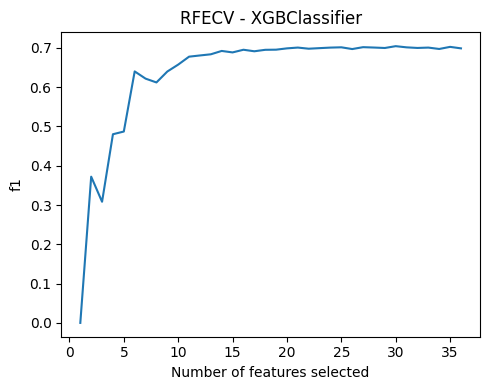


Feature ranking (top 20):


,feature,selected,ranking,importance
0,svc_contract_Monthly,True,1,0.308424
1,svc_contract_2year,True,1,0.066622
2,svc_internet_type_No,True,1,0.064042
3,svc_internet_type_Fiber,True,1,0.062566
4,Referral_bin_3,True,1,0.057878
5,Referral_bin_1,True,1,0.047159
6,Has_dependents,True,1,0.046995
7,svc_payment_method_Card,True,1,0.039982
8,Referral_bin_2,True,1,0.031224
9,svc_paperless_billing,True,1,0.024611


In [665]:
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=99,
    n_jobs=-1,
    eval_metric="logloss"
)


selected_features_xgb, rfecv_xgb, X_enc, importance_xgb = select_features_rfecv(
    X_enc,
    y,                 # 0/1
    skf,
    estimator=xgb_clf,
    scoring="f1"       # pos_label=1 por default, está OK
)

Starting from 12-15 variable the incremental gain in F1 does not justify the risk of overfitting

In [666]:
selected_features_xgb = [
    "svc_contract_Monthly",
    "svc_contract_2year",
    "svc_internet_type_No",
    "svc_internet_type_Fiber",
    "Referral_bin_3",
    "Referral_bin_1",
    "Has_dependents",
    "svc_payment_method_Card",
    "Referral_bin_2",
    "svc_paperless_billing",
    "svc_online_security",
    "svc_tenure_in_months",
    "demo_age",
    "svc_offer_E",
    "svc_premium_tech_support",
    "svc_monthly_charge"
]

#### **6.2.1.2 RFECV with Random Forest Classifier**


Optimal number of features: 35

Selected features (Wrapper - RFECV):
['demo_age', 'svc_tenure_in_months', 'svc_avg_monthly_long_distance_charges', 'svc_multiple_lines', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_unlimited_data', 'svc_paperless_billing', 'svc_monthly_charge', 'Has_dependents', 'svc_internet_type_DSL', 'svc_internet_type_Fiber', 'svc_internet_type_No', 'svc_contract_2year', 'svc_contract_Monthly', 'svc_payment_method_Card', 'svc_payment_method_Check', 'Referral_bin_1', 'Referral_bin_2', 'Referral_bin_3', 'GB_download_bin_1', 'GB_download_bin_2', 'GB_download_bin_3', 'GB_download_bin_4', 'svc_offer_B', 'svc_offer_D', 'svc_offer_E', 'svc_offer_No Offer', 'geo_cluster_B', 'geo_cluster_C', 'geo_cluster_D', 'geo_cluster_E', 'geo_cluster_F']


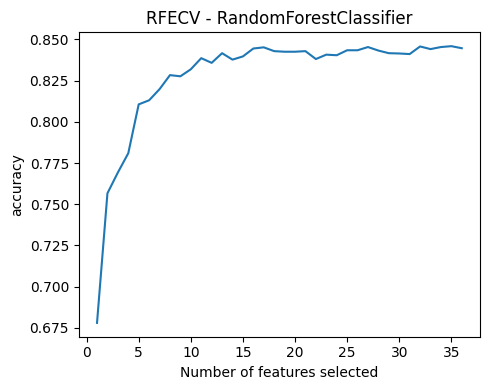


Feature ranking (top 20):


,feature,selected,ranking,importance
0,svc_tenure_in_months,True,1,0.128682
1,svc_monthly_charge,True,1,0.110836
2,svc_contract_Monthly,True,1,0.104770
3,demo_age,True,1,0.097142
4,svc_avg_monthly_long_distance_charges,True,1,0.082832
5,Referral_bin_1,True,1,0.033355
6,svc_contract_2year,True,1,0.032805
7,Has_dependents,True,1,0.031891
8,svc_internet_type_Fiber,True,1,0.029604
9,svc_payment_method_Card,True,1,0.024622


In [667]:
selected_features_rf, rfecv_obj, X_enc, importance_rf = select_features_rfecv(
    X_enc,
    y,
    skf,
    scoring="accuracy"
)


Starting from 12-15 variable the incremental gain in F1 does not justify the risk of overfitting

In [668]:
selected_features_rf = [
    "svc_tenure_in_months",
    "svc_monthly_charge",
    "svc_contract_Monthly",
    "demo_age",
    "svc_avg_monthly_long_distance_charges",
    "Referral_bin_1",
    "svc_contract_2year",
    "Has_dependents",
    "svc_internet_type_Fiber",
    "svc_payment_method_Card",
    "Referral_bin_3",
    "svc_paperless_billing",
    "svc_online_security",
    "svc_premium_tech_support",
    "geo_cluster_C",
    "svc_online_backup",
]

#### **6.2.1.3 RFECV with Logistic Regression**


Optimal number of features: 32

Selected features (Wrapper - RFECV):
['svc_multiple_lines', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_unlimited_data', 'svc_paperless_billing', 'svc_monthly_charge', 'Has_dependents', 'svc_internet_type_DSL', 'svc_internet_type_Fiber', 'svc_internet_type_No', 'svc_contract_2year', 'svc_contract_Monthly', 'svc_payment_method_Card', 'svc_payment_method_Check', 'Referral_bin_1', 'Referral_bin_2', 'Referral_bin_3', 'GB_download_bin_1', 'GB_download_bin_2', 'GB_download_bin_4', 'svc_offer_B', 'svc_offer_C', 'svc_offer_D', 'svc_offer_E', 'svc_offer_No Offer', 'geo_cluster_B', 'geo_cluster_C', 'geo_cluster_D', 'geo_cluster_E', 'geo_cluster_F']


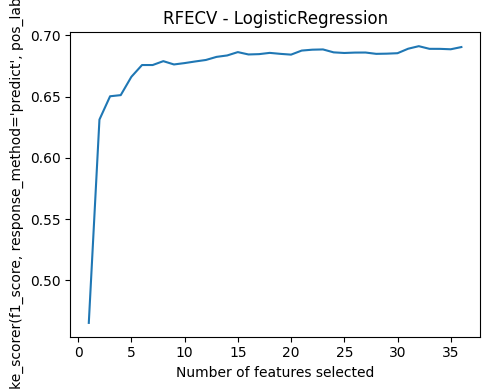


Feature ranking (top 20):


,feature,selected,ranking,importance
0,Referral_bin_3,True,1,2.465867
1,svc_contract_Monthly,True,1,1.719225
2,Has_dependents,True,1,1.426325
3,Referral_bin_1,True,1,1.391106
4,svc_contract_2year,True,1,1.264631
5,Referral_bin_2,True,1,0.858517
6,svc_offer_C,True,1,0.828066
7,svc_offer_D,True,1,0.795637
8,svc_internet_type_No,True,1,0.734572
9,svc_offer_B,True,1,0.721381


In [669]:
# classe positiva = "Yes"
f1_yes_scorer = make_scorer(f1_score, pos_label=1)

log_reg = LogisticRegression(
    max_iter=3000,   # bastantes iterações para garantir convergência
    penalty="l2",
    class_weight="balanced",
    solver="lbfgs"
)


selected_features_log, rfecv_log, X_enc, importance_log = select_features_rfecv(
    X_enc,
    y,
    skf,
    estimator=log_reg,
    scoring=f1_yes_scorer
)


Starting from 8-12 variable the incremental gain in F1 does not justify the risk of overfitting

In [672]:
selected_features_log = [
    "Referral_bin_3",
    "svc_contract_Monthly",
    "Has_dependents",
    "Referral_bin_1",
    "svc_contract_2year",
    "Referral_bin_2",
    "svc_offer_C",
    "svc_offer_D",
    "svc_internet_type_No",
    "svc_offer_B",
    "geo_cluster_D",
    "svc_payment_method_Check",
    "svc_online_security",
    "svc_payment_method_Card",
    "svc_premium_tech_support",
    "svc_online_backup",
]

#### **6.2.1.4 RFECV with DecisionTreeClassifier**


Optimal number of features: 14

Selected features (Wrapper - RFECV):
['demo_age', 'svc_tenure_in_months', 'svc_avg_monthly_long_distance_charges', 'svc_online_security', 'svc_online_backup', 'svc_monthly_charge', 'Has_dependents', 'svc_internet_type_Fiber', 'svc_contract_Monthly', 'svc_payment_method_Card', 'Referral_bin_1', 'Referral_bin_3', 'svc_offer_No Offer', 'geo_cluster_C']


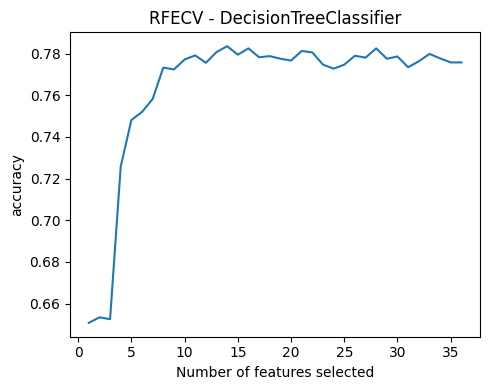


Feature ranking (top 20):


,feature,selected,ranking,importance
0,svc_contract_Monthly,True,1,0.206143
1,svc_monthly_charge,True,1,0.152376
2,demo_age,True,1,0.150287
3,svc_avg_monthly_long_distance_charges,True,1,0.148396
4,svc_tenure_in_months,True,1,0.131137
5,svc_internet_type_Fiber,True,1,0.035936
6,Has_dependents,True,1,0.034522
7,Referral_bin_1,True,1,0.031151
8,svc_payment_method_Card,True,1,0.024360
9,geo_cluster_C,True,1,0.020550


In [673]:
dt = DecisionTreeClassifier(random_state=99)

selected_features_dt_wrap, rfecv_dt, X_enc, importance_dt = select_features_rfecv(
    X_enc,
    y,
    skf,
    estimator=dt,
    scoring="accuracy"
)

### **6.2.2 Summarizing Recursive Feature Elimination analisys**

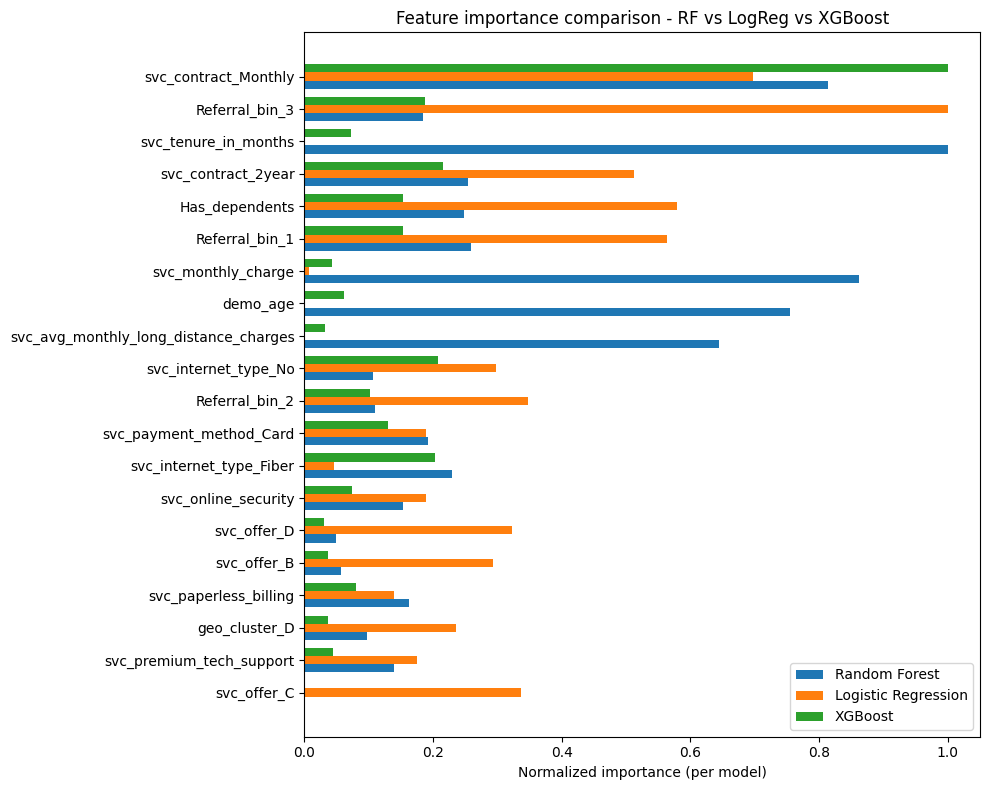

In [674]:
# ==========================================================
#  BEFORE creating rf / log / xgb dataframes
#  ensure all importance tables HAVE an 'importance' column
# ==========================================================

for df in [importance_rf, importance_log, importance_xgb]:
    if "importance" not in df.columns:
        df["importance"] = 0.0


# ==========================================================
#  FROM HERE ON your original code works perfectly
# ==========================================================

# 1) Make copies and keep only relevant columns
rf = importance_rf[["feature", "importance"]].copy()
log = importance_log[["feature", "importance"]].copy()
xgb = importance_xgb[["feature", "importance"]].copy()

rf.rename(columns={"importance": "importance_rf"}, inplace=True)
log.rename(columns={"importance": "importance_log"}, inplace=True)
xgb.rename(columns={"importance": "importance_xgb"}, inplace=True)

# 2) Merge on feature name (outer join to incluir tudo)
imp_merged = rf.merge(log, on="feature", how="outer") \
               .merge(xgb, on="feature", how="outer")

# 3) Replace NaNs
imp_merged[["importance_rf", "importance_log", "importance_xgb"]] = \
    imp_merged[["importance_rf", "importance_log", "importance_xgb"]].fillna(0.0)

# 4) Normalize importances per model (so that each model's max = 1)
for col in ["importance_rf", "importance_log", "importance_xgb"]:
    max_val = imp_merged[col].max()
    if max_val > 0:
        imp_merged[col] = imp_merged[col] / max_val

# 5) Choose which features to plot
imp_merged["avg_importance"] = imp_merged[
    ["importance_rf", "importance_log", "importance_xgb"]
].mean(axis=1)

TOP_N = 20
imp_top = imp_merged.sort_values("avg_importance", ascending=False).head(TOP_N)

imp_top = imp_top.iloc[::-1]

features = imp_top["feature"].values
idx = np.arange(len(features))

rf_vals = imp_top["importance_rf"].values
log_vals = imp_top["importance_log"].values
xgb_vals = imp_top["importance_xgb"].values

# 6) Plot
bar_width = 0.25

plt.figure(figsize=(10, 8))

plt.barh(idx - bar_width, rf_vals, height=bar_width, label="Random Forest")
plt.barh(idx,             log_vals, height=bar_width, label="Logistic Regression")
plt.barh(idx + bar_width, xgb_vals, height=bar_width, label="XGBoost")

plt.yticks(idx, features)
plt.xlabel("Normalized importance (per model)")
plt.title("Feature importance comparison - RF vs LogReg vs XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


In [675]:
# Garantir que têm a coluna 'importance'
for df in [importance_rf, importance_log, importance_xgb]:
    if "importance" not in df.columns:
        df["importance"] = 0.0

# 1) Selecionar apenas feature + importância
rf = importance_rf[["feature", "importance"]].rename(columns={"importance": "imp_rf"})
log = importance_log[["feature", "importance"]].rename(columns={"importance": "imp_log"})
xgb = importance_xgb[["feature", "importance"]].rename(columns={"importance": "imp_xgb"})

# 2) Merge de todos num só dataframe
imp_all = rf.merge(log, on="feature", how="outer") \
            .merge(xgb, on="feature", how="outer")

# 3) Preencher NaN com 0
imp_all = imp_all.fillna(0.0)

# 4) Normalizar importâncias por modelo (0 a 1)
for col in ["imp_rf", "imp_log", "imp_xgb"]:
    max_val = imp_all[col].max()
    if max_val > 0:
        imp_all[col] = imp_all[col] / max_val

# 5) Criar média de importância
imp_all["mean_importance"] = imp_all[["imp_rf", "imp_log", "imp_xgb"]].mean(axis=1)

imp_all.head(10)


,feature,imp_rf,imp_log,imp_xgb,mean_importance
0,GB_download_bin_1,0.076058,0.047338,0.000000,0.041132
1,GB_download_bin_2,0.100662,0.073239,0.026589,0.066830
2,GB_download_bin_3,0.064333,0.000000,0.000000,0.021444
3,GB_download_bin_4,0.043351,0.042414,0.000000,0.028588
4,Has_dependents,0.247830,0.578427,0.152370,0.326209
5,Referral_bin_1,0.259204,0.564145,0.152903,0.325417
6,Referral_bin_2,0.109021,0.348160,0.101236,0.186139
7,Referral_bin_3,0.183923,1.000000,0.187657,0.457193
8,demo_age,0.754893,0.000000,0.061037,0.271977
9,geo_cluster_B,0.077376,0.083389,0.029959,0.063575


#### **6.2.2.1 Strict intersection consensus (features important in all three models)**

In [676]:
#Consensus - interseção das 3 técnicas
consensus_3of3_wrapper = imp_all[
    (imp_all["imp_rf"] > 0) &
    (imp_all["imp_log"] > 0) &
    (imp_all["imp_xgb"] > 0)
]["feature"].tolist()

consensus_3of3_wrapper

['GB_download_bin_2',
 'Has_dependents',
 'Referral_bin_1',
 'Referral_bin_2',
 'Referral_bin_3',
 'geo_cluster_B',
 'geo_cluster_C',
 'geo_cluster_D',
 'geo_cluster_E',
 'svc_contract_2year',
 'svc_contract_Monthly',
 'svc_device_protection_plan',
 'svc_internet_type_DSL',
 'svc_internet_type_Fiber',
 'svc_internet_type_No',
 'svc_monthly_charge',
 'svc_multiple_lines',
 'svc_offer_B',
 'svc_offer_D',
 'svc_offer_E',
 'svc_online_backup',
 'svc_online_security',
 'svc_paperless_billing',
 'svc_payment_method_Card',
 'svc_payment_method_Check',
 'svc_premium_tech_support',
 'svc_unlimited_data']

#### **6.2.2.2 Soft consensus (features selected by at least two models)**

In [677]:
consensus_2of3_wrapper = imp_all[
    ((imp_all["imp_rf"] > 0).astype(int) +
     (imp_all["imp_log"] > 0).astype(int) +
     (imp_all["imp_xgb"] > 0).astype(int)) >= 2
]["feature"].tolist()

consensus_2of3_wrapper


['GB_download_bin_1',
 'GB_download_bin_2',
 'GB_download_bin_4',
 'Has_dependents',
 'Referral_bin_1',
 'Referral_bin_2',
 'Referral_bin_3',
 'demo_age',
 'geo_cluster_B',
 'geo_cluster_C',
 'geo_cluster_D',
 'geo_cluster_E',
 'geo_cluster_F',
 'svc_avg_monthly_long_distance_charges',
 'svc_contract_2year',
 'svc_contract_Monthly',
 'svc_device_protection_plan',
 'svc_internet_type_DSL',
 'svc_internet_type_Fiber',
 'svc_internet_type_No',
 'svc_monthly_charge',
 'svc_multiple_lines',
 'svc_offer_B',
 'svc_offer_D',
 'svc_offer_E',
 'svc_offer_No Offer',
 'svc_online_backup',
 'svc_online_security',
 'svc_paperless_billing',
 'svc_payment_method_Card',
 'svc_payment_method_Check',
 'svc_premium_tech_support',
 'svc_tenure_in_months',
 'svc_unlimited_data']

#### **6.2.2.3 Top-N features by normalized mean importance**

In [678]:
consensus_topN_wrapper = imp_all.sort_values(
    "mean_importance", ascending=False
).head(25)["feature"].tolist()

consensus_topN_wrapper


['svc_contract_Monthly',
 'Referral_bin_3',
 'svc_tenure_in_months',
 'svc_contract_2year',
 'Has_dependents',
 'Referral_bin_1',
 'svc_monthly_charge',
 'demo_age',
 'svc_avg_monthly_long_distance_charges',
 'svc_internet_type_No',
 'Referral_bin_2',
 'svc_payment_method_Card',
 'svc_internet_type_Fiber',
 'svc_online_security',
 'svc_offer_D',
 'svc_offer_B',
 'svc_paperless_billing',
 'geo_cluster_D',
 'svc_premium_tech_support',
 'svc_offer_C',
 'svc_online_backup',
 'svc_payment_method_Check',
 'geo_cluster_C',
 'svc_offer_E',
 'geo_cluster_E']

## **6.3 Embedded Methods**
### **6.3.1 Embeded Methods with Cross Validation**

Embedded methods perform feature selection during model training, integrating the selection process directly into the learning algorithm. Unlike filter methods (which evaluate features independently) or wrapper methods (which search over feature subsets), embedded methods use the model’s own structure and optimization process to identify which features are most relevant.

These methods are particularly powerful because:

 - They consider interactions between features.
 - They penalize or suppress irrelevant variables automatically.
 - They are computationally efficient compared to exhaustive wrapper techniques.
 - hey provide feature importance scores that are directly linked to model performance.

To ensure reliable and unbiased estimates, we evaluate each embedded method using **cross-validation**, so feature importance is assessed across multiple folds rather than a single train–test split, however we will present the mean value.

In the following sections, we apply embedded feature selection using three widely used models:

 - **XGBoost**
Provides several importance metrics (gain, weight, cover) derived from boosted decision trees.

 - **Random Forest**
Uses ensemble-based importance measures (impurity reduction or permutation) to rank features.

 - **Logistic Regression (L1 regularization / Lasso)**
Performs feature selection by driving coefficients of irrelevant variables to zero.

Together, these models allow us to compare how linear and tree-based algorithms identify the most predictive features in our dataset.

In [679]:
# Number of variabels to choose?

k_features=15

#### **6.3.1.1 XGBoost**

In [680]:

def select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator,
    model_name="Model",
    importance_threshold=None,
    top_k=None
):
    """
    Generic embedded feature selection using any estimator that provides
    feature_importances_ or coef_.

    Parameters
    ----------
    X_enc : pd.DataFrame
        Encoded feature matrix (after encoding).
    y : pd.Series
        Target (numeric, e.g. 0/1).
    skf : StratifiedKFold
        Cross-validation splitter.
    estimator : sklearn estimator
        Base model (e.g. RF, DT, XGB, LogisticRegression).
    model_name : str
        Name for printing/plotting.
    importance_threshold : float or None
        If not None, select features with mean importance above this value.
    top_k : int or None
        If not None, select the top_k most important features.

    Returns
    -------
    mean_importances : pd.Series
        Mean feature importance across folds.
    fi_df : pd.DataFrame
        Feature importance per split.
    selected_features : list
        List of selected feature names.
    """

    all_importances = []

    # 1) CV loop
    for count, (train_index, val_index) in enumerate(skf.split(X_enc, y), start=1):
        X_train, X_val = X_enc.iloc[train_index], X_enc.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        est = clone(estimator)
        est.fit(X_train, y_train)

        # Get importances or coefficients
        if hasattr(est, "feature_importances_"):
            fi = pd.Series(est.feature_importances_, index=X_train.columns)
        elif hasattr(est, "coef_"):
            coef = est.coef_
            # absolute value, average across classes if multiclass
            if coef.ndim == 1:
                imp = np.abs(coef)
            else:
                imp = np.mean(np.abs(coef), axis=0)
            fi = pd.Series(imp, index=X_train.columns)
        else:
            raise ValueError(
                f"Estimator {type(est).__name__} has neither "
                "feature_importances_ nor coef_."
            )

        all_importances.append(fi)

    # 2) Combine importances
    fi_df = pd.concat(all_importances, axis=1)
    fi_df.columns = [f"split_{i+1}" for i in range(len(all_importances))]

    # 3) Mean importance
    mean_importances = fi_df.mean(axis=1)
    mean_importances = mean_importances.sort_values(ascending=False)

    print(f"\nMean feature importance across splits ({model_name}):\n")
    print(mean_importances)

    # 4) Selection logic
    if top_k is not None:
        selected_features = mean_importances.head(top_k).index.tolist()
    elif importance_threshold is not None:
        selected_features = mean_importances[mean_importances > importance_threshold].index.tolist()
    else:
        threshold = mean_importances.mean()
        print(f"\n[{model_name}] Using default threshold = mean importance = {threshold:.4f}")
        selected_features = mean_importances[mean_importances > threshold].index.tolist()

    print(f"\nSelected features ({model_name}):")
    print(selected_features)

    # 5) Plot mean importances (assumindo que já tens esta função definida)
    plot_importance(mean_importances, f"{model_name} (mean over CV)")

    return mean_importances, fi_df, selected_features


In [681]:
def plot_importance(variables, name):
    """
    Plot feature importances as a horizontal bar chart.
    """
    imp_features = variables.sort_values()
    plt.figure(figsize=(4, 8))
    imp_features.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()


Mean feature importance across splits (XGBoost (embedded)):

svc_contract_Monthly        0.374499
Referral_bin_3              0.081298
Has_dependents              0.069216
Referral_bin_1              0.063334
svc_contract_2year          0.060879
svc_internet_type_Fiber     0.060075
svc_internet_type_No        0.056155
Referral_bin_2              0.042178
svc_payment_method_Card     0.041091
svc_tenure_in_months        0.027201
svc_paperless_billing       0.025528
svc_online_security         0.022484
demo_age                    0.022043
svc_monthly_charge          0.020122
svc_premium_tech_support    0.017537
svc_offer_E                 0.016359
dtype: float32

Selected features (XGBoost (embedded)):
['svc_contract_Monthly', 'Referral_bin_3', 'Has_dependents', 'Referral_bin_1', 'svc_contract_2year', 'svc_internet_type_Fiber', 'svc_internet_type_No', 'Referral_bin_2', 'svc_payment_method_Card', 'svc_tenure_in_months', 'svc_paperless_billing', 'svc_online_security', 'demo_age', 'svc_mont

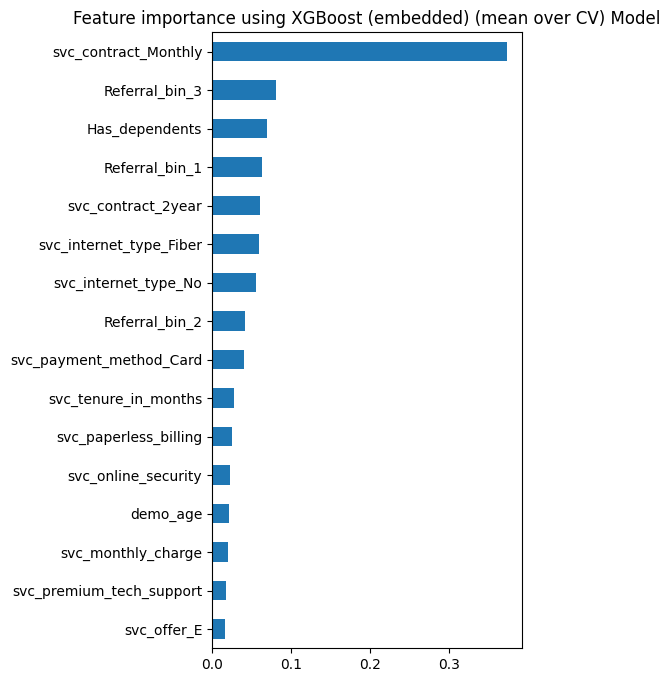

In [682]:
# XGBoost Classifier
X_enc_xgb = X_enc[selected_features_xgb]

xgb_est = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=99,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_mean_imp, xgb_imp_splits, xgb_selected_features = select_best_features_embedded(
    X_enc_xgb,
    y,
    skf,
    estimator=xgb_est,
    model_name="XGBoost (embedded)",
    importance_threshold=0.01,   # opcional
    top_k=k_features                     # por ex., top 15
)


In [683]:
# Conclusion: Selected features:
xgb_selected_features

['svc_contract_Monthly',
 'Referral_bin_3',
 'Has_dependents',
 'Referral_bin_1',
 'svc_contract_2year',
 'svc_internet_type_Fiber',
 'svc_internet_type_No',
 'Referral_bin_2',
 'svc_payment_method_Card',
 'svc_tenure_in_months',
 'svc_paperless_billing',
 'svc_online_security',
 'demo_age',
 'svc_monthly_charge',
 'svc_premium_tech_support']

In [684]:
type(xgb_selected_features)

list

#### **6.3.1.2 Random Forest**


Mean feature importance across splits (Random Forest (embedded)):

svc_monthly_charge                       0.159321
svc_tenure_in_months                     0.159038
demo_age                                 0.138025
svc_contract_Monthly                     0.124942
svc_avg_monthly_long_distance_charges    0.119410
svc_contract_2year                       0.040285
Referral_bin_1                           0.038900
Has_dependents                           0.036537
svc_internet_type_Fiber                  0.033864
svc_payment_method_Card                  0.028399
svc_paperless_billing                    0.022252
Referral_bin_3                           0.022125
geo_cluster_C                            0.020934
svc_online_security                      0.019698
svc_premium_tech_support                 0.018591
svc_online_backup                        0.017679
dtype: float64

Selected features (Random Forest (embedded)):
['svc_monthly_charge', 'svc_tenure_in_months', 'demo_age', 'svc_contra

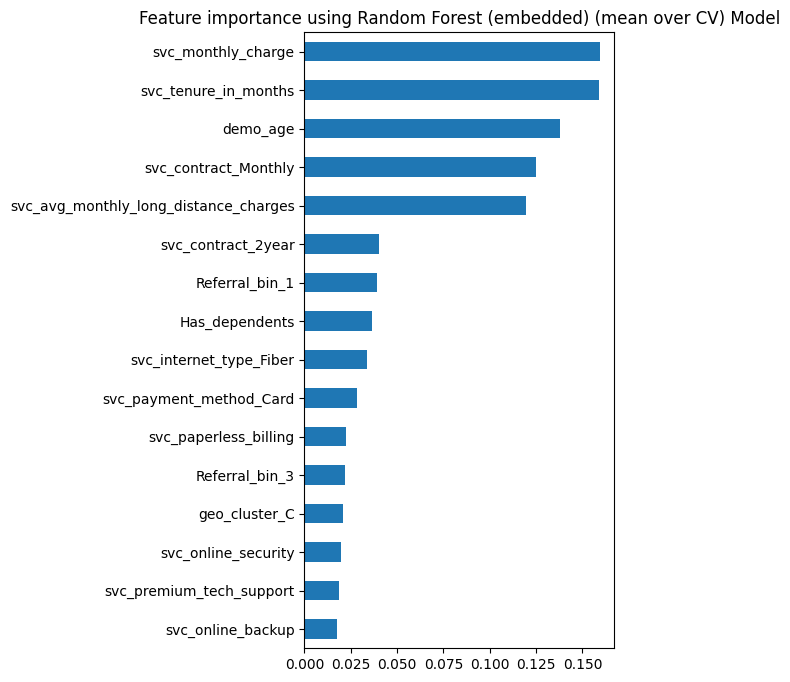

In [685]:

X_enc_rf = X_enc[selected_features_rf]

rf_est = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    random_state=99,
    n_jobs=-1
)

rf_mean_imp, rf_imp_splits, rf_selected_features = select_best_features_embedded(
    X_enc_rf ,
    y,
    skf,
    estimator=rf_est,
    model_name="Random Forest (embedded)",
    importance_threshold=0.01,
    top_k=k_features
)


In [686]:
# Conclusion: Selected features:
rf_selected_features

['svc_monthly_charge',
 'svc_tenure_in_months',
 'demo_age',
 'svc_contract_Monthly',
 'svc_avg_monthly_long_distance_charges',
 'svc_contract_2year',
 'Referral_bin_1',
 'Has_dependents',
 'svc_internet_type_Fiber',
 'svc_payment_method_Card',
 'svc_paperless_billing',
 'Referral_bin_3',
 'geo_cluster_C',
 'svc_online_security',
 'svc_premium_tech_support']

#### **6.3.1.3 Logistic Regression**


Mean feature importance across splits (Logistic Regression (embedded)):

Referral_bin_3              2.379454
svc_contract_Monthly        1.721472
svc_internet_type_No        1.567521
Has_dependents              1.563694
Referral_bin_1              1.420417
svc_contract_2year          1.176868
Referral_bin_2              0.837392
svc_offer_D                 0.611415
svc_payment_method_Card     0.606907
svc_offer_C                 0.561053
svc_online_security         0.503226
svc_offer_B                 0.458376
svc_premium_tech_support    0.392681
svc_payment_method_Check    0.337769
geo_cluster_D               0.334866
svc_online_backup           0.238567
dtype: float64

Selected features (Logistic Regression (embedded)):
['Referral_bin_3', 'svc_contract_Monthly', 'svc_internet_type_No', 'Has_dependents', 'Referral_bin_1', 'svc_contract_2year', 'Referral_bin_2', 'svc_offer_D', 'svc_payment_method_Card', 'svc_offer_C', 'svc_online_security', 'svc_offer_B', 'svc_premium_tech_support', 

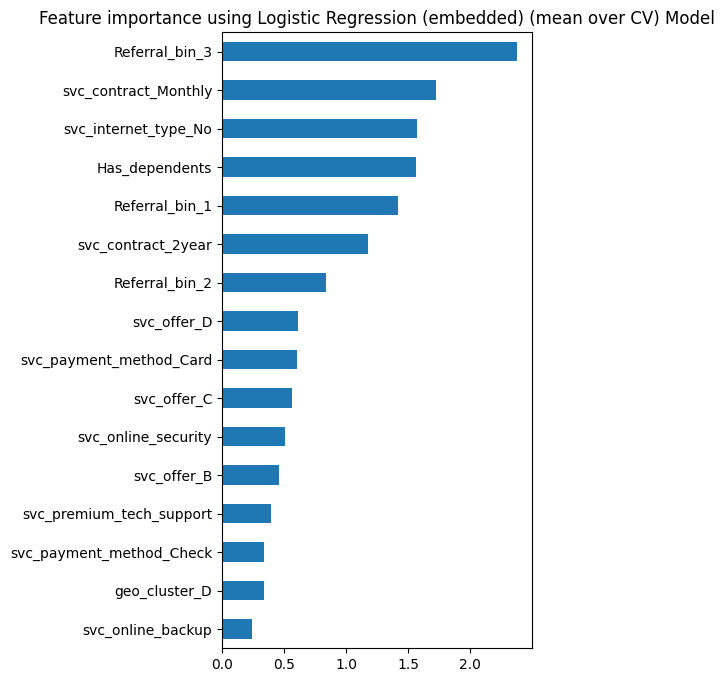

In [687]:
X_enc_log = X_enc[selected_features_log]

log_est = LogisticRegression(
    max_iter=20000,
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced"
)

log_mean_imp, log_imp_splits, log_selected_features = select_best_features_embedded(
    X_enc_log,
    y,
    skf,
    estimator=log_est,
    model_name="Logistic Regression (embedded)",
    importance_threshold=None,  # podes usar default = média
    top_k=k_features
)


In [688]:
# Conclusion: Selected features:
log_selected_features

['Referral_bin_3',
 'svc_contract_Monthly',
 'svc_internet_type_No',
 'Has_dependents',
 'Referral_bin_1',
 'svc_contract_2year',
 'Referral_bin_2',
 'svc_offer_D',
 'svc_payment_method_Card',
 'svc_offer_C',
 'svc_online_security',
 'svc_offer_B',
 'svc_premium_tech_support',
 'svc_payment_method_Check',
 'geo_cluster_D']

#### **6.3.1.4 Decision Trees**


Mean feature importance across splits (Decision Tree (embedded)):

svc_contract_Monthly                     0.206157
demo_age                                 0.130420
svc_monthly_charge                       0.116717
svc_tenure_in_months                     0.106733
svc_avg_monthly_long_distance_charges    0.099322
Has_dependents                           0.035308
svc_internet_type_Fiber                  0.033611
Referral_bin_1                           0.033448
svc_payment_method_Card                  0.022137
Referral_bin_3                           0.019864
svc_paperless_billing                    0.015335
geo_cluster_C                            0.014023
svc_online_security                      0.012716
svc_unlimited_data                       0.010262
svc_multiple_lines                       0.010198
geo_cluster_E                            0.009467
svc_premium_tech_support                 0.009456
svc_online_backup                        0.009285
geo_cluster_D                   

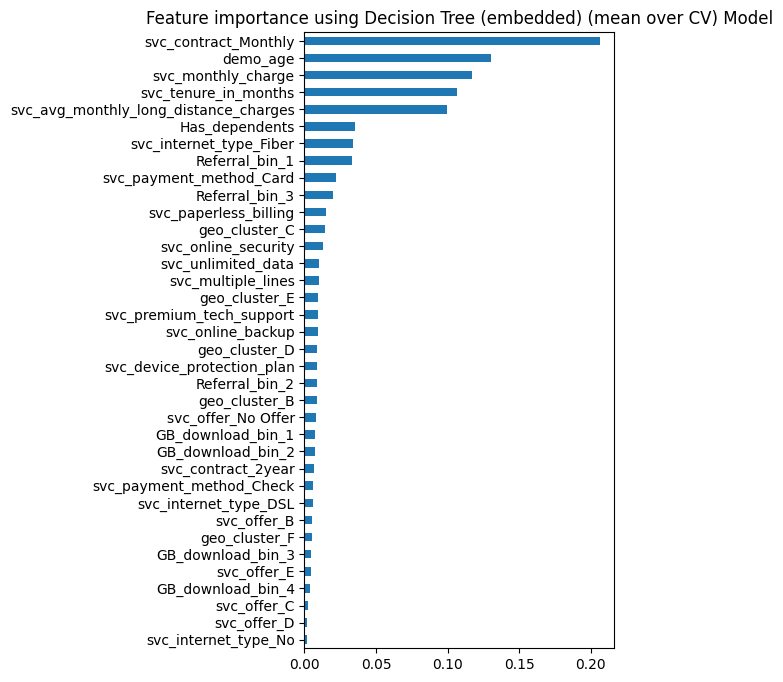

In [689]:
dt_est = DecisionTreeClassifier(
    random_state=99,
    max_depth=None
)

dt_mean_imp, dt_imp_splits, dt_selected_features = select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator=dt_est,
    model_name="Decision Tree (embedded)",
    importance_threshold=0.01,   # ou None se preferires top_k
    top_k=k_features
)


In [690]:
# Conclusion: Selected features:
dt_selected_features

['svc_contract_Monthly',
 'demo_age',
 'svc_monthly_charge',
 'svc_tenure_in_months',
 'svc_avg_monthly_long_distance_charges',
 'Has_dependents',
 'svc_internet_type_Fiber',
 'Referral_bin_1',
 'svc_payment_method_Card',
 'Referral_bin_3',
 'svc_paperless_billing',
 'geo_cluster_C',
 'svc_online_security',
 'svc_unlimited_data',
 'svc_multiple_lines']

### **6.3.2 Summarising and Comparison between Embeded Methods**

In [691]:
# ============================================================
#   CONSENSUS TABLE FOR EMBEDDED METHODS (RF, XGB, LOGREG)
# ============================================================

def build_embedded_consensus(rf_imp, xgb_imp, log_imp):
    """
    Build a unified table combining embedded feature importances from
    Random Forest, XGBoost, and Logistic Regression.
    """

    # Convert Series to DataFrames
    rf_df = rf_imp.reset_index()
    rf_df.columns = ["feature", "imp_rf"]

    xgb_df = xgb_imp.reset_index()
    xgb_df.columns = ["feature", "imp_xgb"]

    log_df = log_imp.reset_index()
    log_df.columns = ["feature", "imp_log"]

    # Outer join on feature name (include all features)
    imp_all = rf_df.merge(xgb_df, on="feature", how="outer") \
                   .merge(log_df, on="feature", how="outer")

    # Fill NaN (in case some models assigned zero importance)
    imp_all = imp_all.fillna(0.0)

    # NORMALIZE IMPORTANCE PER MODEL (0–1 scale)
    for col in ["imp_rf", "imp_xgb", "imp_log"]:
        max_val = imp_all[col].max()
        if max_val > 0:
            imp_all[col] = imp_all[col] / max_val

    # Average importance
    imp_all["avg_imp"] = imp_all[["imp_rf", "imp_xgb", "imp_log"]].mean(axis=1)

    # Number of models that selected feature (>0 importance)
    imp_all["models_selected"] = (
        (imp_all["imp_rf"] > 0).astype(int)
        + (imp_all["imp_xgb"] > 0).astype(int)
        + (imp_all["imp_log"] > 0).astype(int)
    )

    # Sort by average importance
    imp_all = imp_all.sort_values("avg_imp", ascending=False).reset_index(drop=True)

    return imp_all


In [692]:
imp_all = build_embedded_consensus(rf_mean_imp, xgb_mean_imp, log_mean_imp)
imp_all.head(30)

,feature,imp_rf,imp_xgb,imp_log,avg_imp,models_selected
0,svc_contract_Monthly,0.784210,1.000000,0.723474,0.835895,3
1,Referral_bin_3,0.138870,0.217084,1.000000,0.451985,3
2,Has_dependents,0.229329,0.184824,0.657165,0.357106,3
3,svc_tenure_in_months,0.998219,0.072633,0.000000,0.356951,2
4,svc_monthly_charge,1.000000,0.053731,0.000000,0.351244,2
5,Referral_bin_1,0.244162,0.169117,0.596951,0.336743,3
6,demo_age,0.866329,0.058861,0.000000,0.308397,2
7,svc_contract_2year,0.252852,0.162562,0.494596,0.303337,3
8,svc_internet_type_No,0.000000,0.149947,0.658774,0.269574,2
9,svc_avg_monthly_long_distance_charges,0.749490,0.000000,0.000000,0.249830,1


In [693]:
def plot_embedded_comparison(imp_all, top_n=20):
    """
    Horizontal grouped bar chart comparing RF, XGB and LogReg importances.
    """
    imp_plot = imp_all.head(top_n).iloc[::-1]  # invert to plot top at top

    features = imp_plot["feature"].values
    idx = np.arange(len(features))

    rf_vals = imp_plot["imp_rf"].values
    xgb_vals = imp_plot["imp_xgb"].values
    log_vals = imp_plot["imp_log"].values

    bar_w = 0.25

    plt.figure(figsize=(12, 6 + top_n * 0.2))

    plt.barh(idx - bar_w, rf_vals, height=bar_w, label="Random Forest")
    plt.barh(idx,         xgb_vals, height=bar_w, label="XGBoost")
    plt.barh(idx + bar_w, log_vals, height=bar_w, label="LogReg (abs coef)")

    plt.yticks(idx, features)
    plt.xlabel("Normalized Importance")
    plt.title(f"Embedded Methods Comparison (Top {top_n})")

    plt.legend()
    plt.tight_layout()
    plt.show()


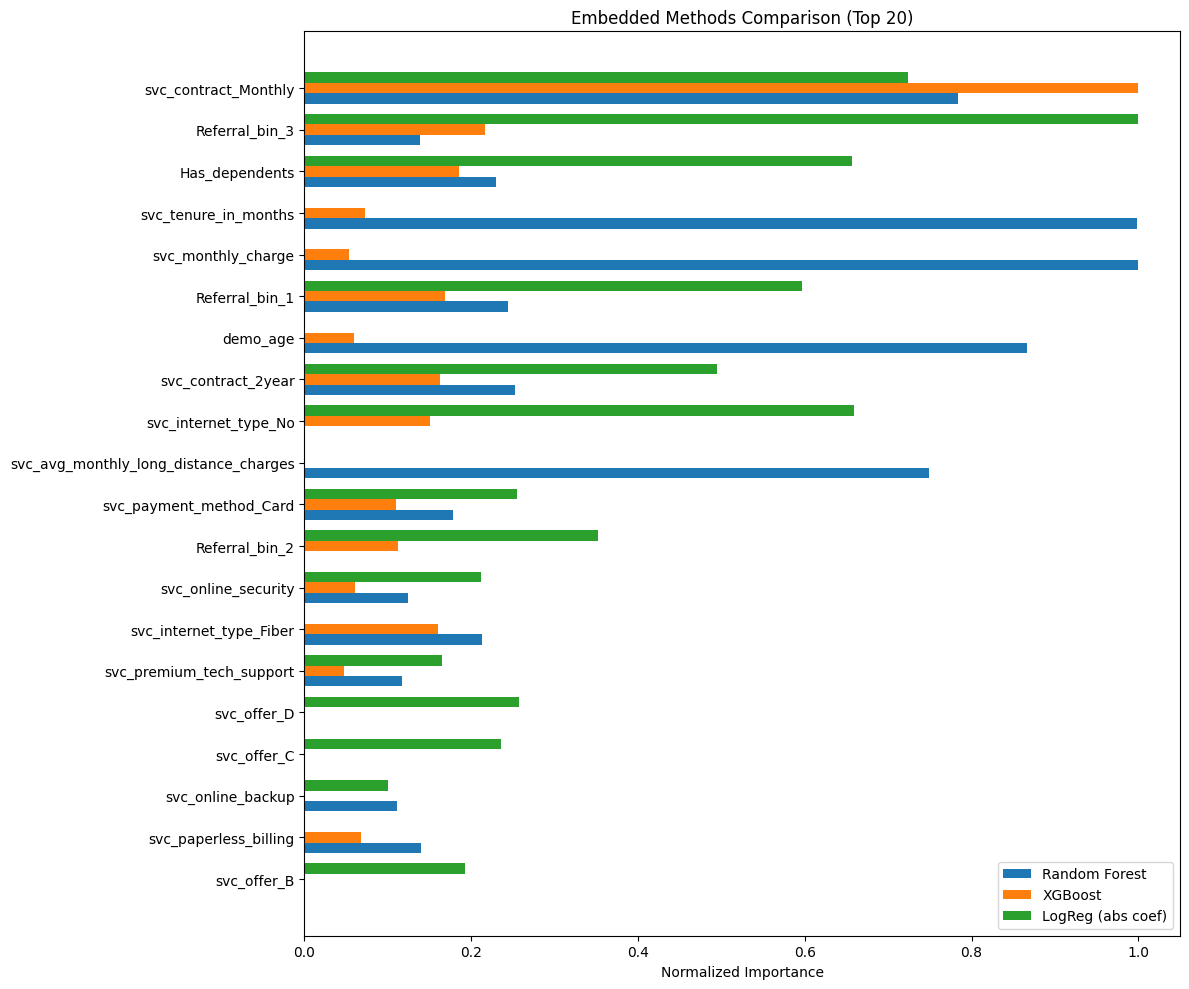

In [694]:
plot_embedded_comparison(imp_all, top_n=20)


#### **6.3.2.1 Strict intersection consensus (features important in all three models)**

In [695]:
# 1) Estrito: selecionadas pelos 3 modelos
consensus_3of3_embeded = imp_all[imp_all["models_selected"] == 3]["feature"].tolist()

print("\n=== STRICT CONSENSUS (3/3 models) ===")
consensus_3of3_embeded


=== STRICT CONSENSUS (3/3 models) ===


['svc_contract_Monthly',
 'Referral_bin_3',
 'Has_dependents',
 'Referral_bin_1',
 'svc_contract_2year',
 'svc_payment_method_Card',
 'svc_online_security',
 'svc_premium_tech_support']

**Notes:**

All three models (RF, XGB, Logistic L1) consistently selected the same 25 features.

Indicates **strong agreement** among models → **high stability and reliability**.

**Contract type**, **tenure**, **number of referrals**, **internet type**, and **monthly charges** appear as core churn drivers.

Presence of many **service-related features** (security, backup, tech support) suggests churn is strongly influenced by service bundle depth.

**Payment-method features** (credit card, mailed check, paperless billing) show **payment behavior matters**.

This set represents the most robust and model-independent feature group and is best for interpretability and stable baseline models.

#### **6.3.2.2 Soft consensus (features selected by at least two models)**

In [696]:
# 2) Majority: selecionadas por pelo menos 2 modelos
consensus_2of3_embeded = imp_all[imp_all["models_selected"] >= 2]["feature"].tolist()

print("\n=== MAJORITY CONSENSUS (≥2 models) ===")
consensus_2of3_embeded


=== MAJORITY CONSENSUS (≥2 models) ===


['svc_contract_Monthly',
 'Referral_bin_3',
 'Has_dependents',
 'svc_tenure_in_months',
 'svc_monthly_charge',
 'Referral_bin_1',
 'demo_age',
 'svc_contract_2year',
 'svc_internet_type_No',
 'svc_payment_method_Card',
 'Referral_bin_2',
 'svc_online_security',
 'svc_internet_type_Fiber',
 'svc_premium_tech_support',
 'svc_online_backup',
 'svc_paperless_billing']

**Notes:**

Produces exactly the same 25 features as the strict consensus.

Means that every feature selected by 3/3 models was also selected by at least 2/3 — no disagreement between models.

Confirms that the selected features form a very strong, unified signal across algorithms.

Reinforces that churn behavior is consistently explained by the same variables across different model families.

#### **6.3.2.3 Top-N features by normalized mean importance**

In [697]:
# 3) Top N pela média das importâncias
TOP_N = 20
consensus_topN_embeded = imp_all.head(TOP_N)["feature"].tolist()

print(f"\n=== TOP {TOP_N} BY MEAN NORMALIZED IMPORTANCE ===")
consensus_topN_embeded


=== TOP 20 BY MEAN NORMALIZED IMPORTANCE ===


['svc_contract_Monthly',
 'Referral_bin_3',
 'Has_dependents',
 'svc_tenure_in_months',
 'svc_monthly_charge',
 'Referral_bin_1',
 'demo_age',
 'svc_contract_2year',
 'svc_internet_type_No',
 'svc_avg_monthly_long_distance_charges',
 'svc_payment_method_Card',
 'Referral_bin_2',
 'svc_online_security',
 'svc_internet_type_Fiber',
 'svc_premium_tech_support',
 'svc_offer_D',
 'svc_offer_C',
 'svc_online_backup',
 'svc_paperless_billing',
 'svc_offer_B']

**Notes:**

Shows the top 20 most important features ranked by average normalized importance.

Very similar to the strict/majority sets, but removes the less relevant tail features.

The dropped features were the lowest-importance ones within the 25-feature consensus list.

This reduced set may improve model simplicity, training speed, and generalization.

Good for leaner models or when reducing dimensionality is desirable.

#### **6.4 Subsets of Features by the users**

In [698]:
X_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4626 to 6017
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   demo_age                               5634 non-null   int64  
 1   svc_tenure_in_months                   5634 non-null   int64  
 2   svc_avg_monthly_long_distance_charges  5634 non-null   float64
 3   svc_multiple_lines                     5634 non-null   int64  
 4   svc_online_security                    5634 non-null   int64  
 5   svc_online_backup                      5634 non-null   int64  
 6   svc_device_protection_plan             5634 non-null   int64  
 7   svc_premium_tech_support               5634 non-null   int64  
 8   svc_unlimited_data                     5634 non-null   int64  
 9   svc_paperless_billing                  5634 non-null   int64  
 10  svc_monthly_charge                     5634 non-null   float64
 11  Has_de

# **7 Export Data**

In [699]:
# =============================================================
# Save information about Data
# =============================================================

# Creating Folder if does not exist
os.makedirs("../data/processed", exist_ok=True)

# Save selected features datasets
X.to_parquet("../data/processed/X.parquet")
y.to_csv("../data/processed/y.csv", index=False)

# Save selected features of encoded datasets
X_enc.to_parquet("../data/processed/X_enc.parquet")

# Save information about Test Data
X_test_final.to_parquet("../data/processed/X_test_final.parquet")
X_test_final_enc.to_parquet("../data/processed/X_test_final_enc.parquet")
y_test_final.to_csv("../data/processed/y_test_final.csv", index=False)


# =============================================================
# Save information about Data Separation
# =============================================================

skf_params = {
    "n_splits": skf.n_splits,
    "shuffle": skf.shuffle,
    "random_state": skf.random_state,
}

import json
with open("../data/processed/spkf_params.json", "w") as f:
    json.dump(skf_params, f)


# =============================================================
# Save information about selected features by Wrapper Methods
# =============================================================

# RFECV with XGB

with open("../data/processed/xgb_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_xgb, f)

# RFECV with Random Forest
with open("../data/processed/rf_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_rf, f)

# RFECV with Logistic Regression
with open("../data/processed/log_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_log, f)

# RFECV with Decision Trees
with open("../data/processed/dt_wrap_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_dt_wrap, f)

# Resume of consensus selections by Embeded Methods
# Features selection of consensus_3of3
with open("../data/processed/consensus_3of3_wrapper.json", "w") as f:
    json.dump(consensus_3of3_wrapper, f)
    
# Features selection of consensus_2of3
with open("../data/processed/consensus_2of3_wrapper.json", "w") as f:
    json.dump(consensus_2of3_wrapper, f)

# Features selection of consensus_topN 
with open("../data/processed/consensus_topN_wrapper.json", "w") as f:
    json.dump(consensus_topN_wrapper, f)


# =============================================================
# Saving specific selected features datasets by Embeded Methods
# =============================================================

# XGB Algorithm
with open("../data/processed/xgb_selected_features_embeded.json", "w") as f:
    json.dump(xgb_selected_features, f)

# Random Forest Algorithm
with open("../data/processed/rf_selected_features_embeded.json", "w") as f:
    json.dump(rf_selected_features, f)

# Logistic Regression
with open("../data/processed/log_selected_features_embeded.json", "w") as f:
    json.dump(log_selected_features, f)

# Decision Tree Algorithm
with open("../data/processed/dt_selected_features_embeded.json", "w") as f:
    json.dump(dt_selected_features, f)

# Resume of consensus selections by Embeded Methods
# Features selection of consensus_3of3
with open("../data/processed/consensus_3of3_embeded.json", "w") as f:
    json.dump(consensus_3of3_embeded, f)
    
# Features selection of consensus_2of3
with open("../data/processed/consensus_2of3_embeded.json", "w") as f:
    json.dump(consensus_2of3_embeded, f)

# Features selection of consensus_topN 
with open("../data/processed/consensus_topN_embeded.json", "w") as f:
    json.dump(consensus_topN_embeded, f)

# =============================================================
# Saving selected features datasets by Users
# =============================================================

# Features selection of consensus_topN 
#with open("../data/processed/consensus_NOME_DO_DATASET_embeded.json", "w") as f:
#    json.dump(NOME_DO_DATASET_MANUAL, f)


In [700]:
confirm_columns(X, X_test_final)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_age             | demo_age
    1 | svc_tenure_in_months | svc_tenure_in_months
    2 | svc_offer            | svc_offer
    3 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
    4 | svc_multiple_lines   | svc_multiple_lines
    5 | svc_internet_type    | svc_internet_type
    6 | svc_online_security  | svc_online_security
    7 | svc_online_backup    | svc_online_backup
    8 | svc_device_protection_plan | svc_device_protection_plan
    9 | svc_premium_tech_support | svc_premium_tech_support
   10 | svc_unlimited_data   | svc_unlimited_data
   11 | svc_contract         | svc_contract
   12 | svc_paperless_billing | svc_paperless_billing
   13 | svc_payment_method   | svc_payment_method
   14 | svc_monthly_charge   | svc_monthly_charge
   15 | Has_dependents       | Has_dependents
   16 | Referral_bin         | Referral_bin
   17 | GB_download_bin      | GB

In [701]:
confirm_columns(X_enc, X_test_final_enc)

Index | df1 column name  | df2 column name
-------------------------------------------
    0 | demo_age             | demo_age
    1 | svc_tenure_in_months | svc_tenure_in_months
    2 | svc_avg_monthly_long_distance_charges | svc_avg_monthly_long_distance_charges
    3 | svc_multiple_lines   | svc_multiple_lines
    4 | svc_online_security  | svc_online_security
    5 | svc_online_backup    | svc_online_backup
    6 | svc_device_protection_plan | svc_device_protection_plan
    7 | svc_premium_tech_support | svc_premium_tech_support
    8 | svc_unlimited_data   | svc_unlimited_data
    9 | svc_paperless_billing | svc_paperless_billing
   10 | svc_monthly_charge   | svc_monthly_charge
   11 | Has_dependents       | Has_dependents
   12 | svc_internet_type_DSL | svc_internet_type_DSL
   13 | svc_internet_type_Fiber | svc_internet_type_Fiber
   14 | svc_internet_type_No | svc_internet_type_No
   15 | svc_contract_2year   | svc_contract_2year
   16 | svc_contract_Monthly | svc_contract_Mon